In [41]:
import sys, io
import math
import numpy as np
import pandas as pd
from scipy.optimize import nnls
from fractions import Fraction
from sympy import factorint
from itertools import product
from typing import List, Optional, Tuple
import random



https://oeis.org/A003586


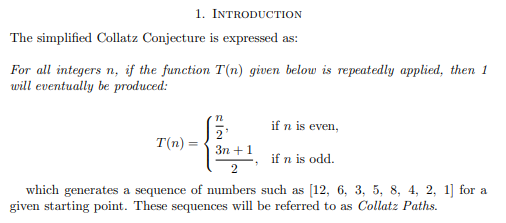

In [42]:
def C(n):
    """ Compute next value in simplified Collatz sequence.
    """
    if n & 1 == 0:
        return n//2
    else:
        return (3*n + 1)//2
#
def L_C(n):
    """ Compute binary label-string for a given Collatz number
    """
    if n == 1:
        return "1"

    S = ""
    while n != 1:
        if n & 1 == 0:
            n = n//2
            S = S + "1"
        else:
            n = (3*n + 1)//2
            S = S + "0"
    return S
#
def collatzVector(collatzNumber):
    chain = [collatzNumber]
    while collatzNumber != 1:
        if (collatzNumber & 1) == 0:
            collatzNumber = collatzNumber // 2
        else:
            collatzNumber = (3 * collatzNumber + 1) // 2
        chain.append(collatzNumber)
    chain.append(chain[-2])
    return np.array(chain)
    
def collatzPath(collatzNumber):
    path = []
    while collatzNumber != 1:
        if (collatzNumber & 1) == 0:
            collatzNumber = collatzNumber // 2
            path.append("1")
        else:
            collatzNumber = (3 * collatzNumber + 1) // 2
            path.append("0")
    return "".join(path)
#

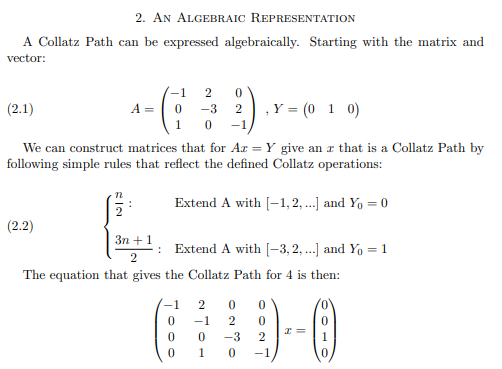

In [43]:
def Ay_L(L):
    """ Generate A matrix and y vector from label string
    """
    rank = len(L) + 2    
    A = np.zeros((rank,rank))
    y = np.zeros((rank))
    for row in range(rank-3):
        if L[row] == "1":
            a_val = -1.0
            y_val = 0.0
        else:
            a_val = -3.0
            y_val = 1.0
        A[row][row] = a_val
        A[row][row+1] = 2.0
        y[row] = y_val
    #
    # Last 3 rows are always the same
    row = rank - 3
    A[row][row] = -1
    A[row][row+1] = 2
    y[row] = 0
    row = rank - 2
    A[row][row] = -3
    A[row][row+1] = 2
    y[row] = 1
    row = rank - 1
    A[row][row] = -1
    A[row][row-2] = 1
    y[row] = 0
    
    return A, y
#

In [44]:
Ay_L("00111")

(array([[-3.,  2.,  0.,  0.,  0.,  0.,  0.],
        [ 0., -3.,  2.,  0.,  0.,  0.,  0.],
        [ 0.,  0., -1.,  2.,  0.,  0.,  0.],
        [ 0.,  0.,  0., -1.,  2.,  0.,  0.],
        [ 0.,  0.,  0.,  0., -1.,  2.,  0.],
        [ 0.,  0.,  0.,  0.,  0., -3.,  2.],
        [ 0.,  0.,  0.,  0.,  1.,  0., -1.]]),
 array([1., 1., 0., 0., 0., 1., 0.]))

In [45]:
def solve_Ay_L(L):
    """ Solve for the x vector given the label-string
    """
    A, y = Ay_L(L)
    return A, np.linalg.solve(A, y), y
#

In [46]:
solve_Ay_L("00111")

(array([[-3.,  2.,  0.,  0.,  0.,  0.,  0.],
        [ 0., -3.,  2.,  0.,  0.,  0.,  0.],
        [ 0.,  0., -1.,  2.,  0.,  0.,  0.],
        [ 0.,  0.,  0., -1.,  2.,  0.,  0.],
        [ 0.,  0.,  0.,  0., -1.,  2.,  0.],
        [ 0.,  0.,  0.,  0.,  0., -3.,  2.],
        [ 0.,  0.,  0.,  0.,  1.,  0., -1.]]),
 array([3., 5., 8., 4., 2., 1., 2.]),
 array([1., 1., 0., 0., 0., 1., 0.]))

In [47]:
def x0_L(L):
    """ Get the x[0] value given a label-string
    """
    A, x, y = solve_Ay_L(L)
    return round(x[0])  # clean up mantisa garbage
#

In [48]:
x0_L("00111")

3

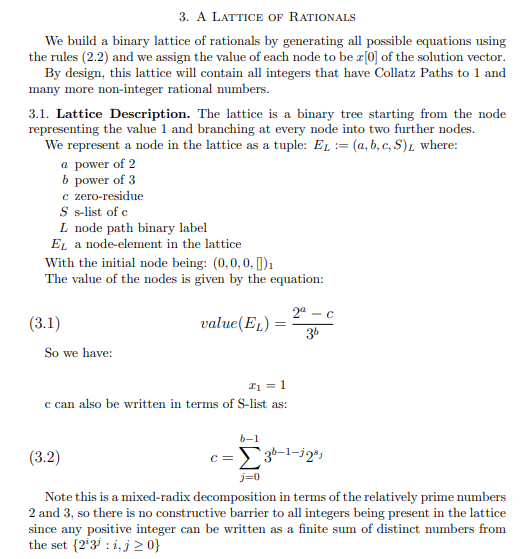

In [49]:
def countZeros(label):
    zero_count = 0
    for bit in label:
        if bit == "0":
            zero_count += 1
    return zero_count
#

def Z(L):
    """ Indexes of zeros in label string
    """
    for i in range(len(L)):
        if L[i] == "0":
            yield i
#

In [50]:
list(Z("00111"))

[0, 1]

In [51]:
def a_b_c_S(L):
    """ Get the (power-of-two, power-of-three, zero-sum-accumulator) tuple for a node given its label
    """
    a = len(L)
    b = 0
    for bit in L:
        if bit == "0":
            b += 1
    ZZ = [(j,i) for j, i in enumerate(Z(L))]
    c = sum((3 ** (b - j - 1)) * (2 ** (i)) for j, i in ZZ)
    S = [zz[1] for zz in ZZ]
    return (a,b,c,S)

In [52]:
a_b_c_S("01")

(2, 1, 1, [0])

In [53]:
a_b_c_S("00111")

(5, 2, 5, [0, 1])

In [54]:
def val_a_b_c(a_b_c):
    """ Get the value for a node given the tuple (power-of-two, power-of-three, zero-sum-accumulator)
    """
    a, b, c = a_b_c
    f = Fraction( ((2**a) - c), (3**b) )
    return (f.numerator, f.denominator)
#
def val_a_b_c_S(a_b_c_S):
    a_b_c = (a_b_c_S[0], a_b_c_S[1], a_b_c_S[2])
    return val_a_b_c(a_b_c)
#

In [55]:
val_a_b_c((5, 2, 5))

(3, 1)

In [56]:
def val_L(L):
    """ Get the value for a node given the label string
    """
    return val_a_b_c_S(a_b_c_S(L))
#

In [57]:
val_L("00111")

(3, 1)

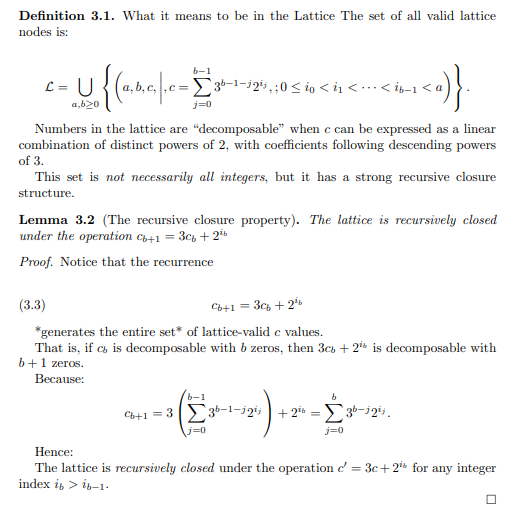

# Full Mixed Radix representation


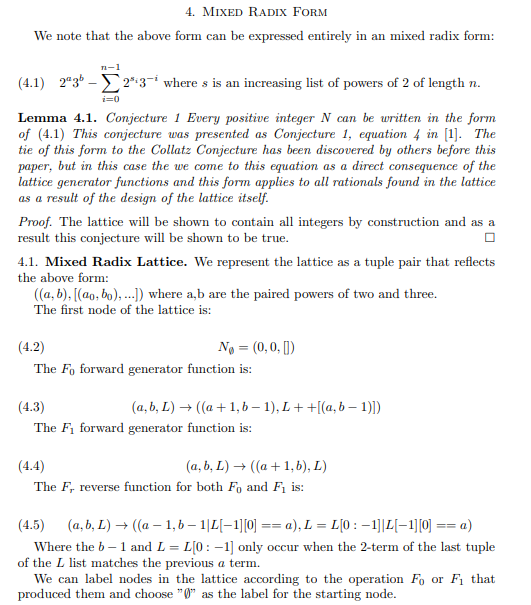

In [58]:
N_i = ((0,0), [])

In [59]:
def mr_TupItemValue(a_b, a_0):
    """ Value of (a, b) tuple with a_0 added to b so we are not dealing with float limitations
    """
    a,b = a_b
    return (2**a)*(3**(a_0 + b))
#
def mrTupValue(mr_tup):
    """ Compute the value of the given mrTup

        Returns value as a cannonical (numerator, denominator) pair
    """
    # Multiplying the numerator by 3 ** the generation keeps us in integer land
    a_0 = mr_tup[0][0]
    total = mr_TupItemValue(mr_tup[0], a_0)
    for a_b in mr_tup[1]:
        total -= mr_TupItemValue(a_b, a_0)
    frac = Fraction(total, 3**a_0)
    return (frac.numerator, frac.denominator)
#

In [60]:
mrTupValue(N_i)

(1, 1)

In [61]:
def F_0(mr_tup):
    u_tup, v_list = mr_tup
    a,b = u_tup
    u_tup_ = (a+1, b-1)
    if len(v_list) > 0:
        b_ = v_list[-1][1] - 1
    else:
        b_ = b - 1
    v_list = [(vt[0], vt[1]) for vt in v_list] + [(a, b_ )]
    return (u_tup_, v_list)
#

In [62]:
# Terse version for math conversion
def F_0(mr_tup):
    return ( (mr_tup[0][0]+1, mr_tup[0][1]-1), mr_tup[1] + [(mr_tup[0][0], mr_tup[0][1]-1)] )
#

In [63]:
def F_1(mr_tup):
    u_tup, v_list = mr_tup
    a,b = u_tup
    u_tup = (a+1, b)
    return (u_tup, v_list)
#

In [64]:
def F_1(mr_tup):
    return ((mr_tup[0][0]+1, mr_tup[0][1]), mr_tup[1])
#

In [65]:
mrTupValue(F_1(N_i))

(2, 1)

In [66]:
F_0(N_i)

((1, -1), [(0, -1)])

In [67]:
mrTupValue(F_0(N_i))

(1, 3)

In [68]:
mrTupValue(F_0(F_0(N_i)))

(-1, 9)

In [69]:
F_0(F_0(N_i))
# 4/9 - 1/9 -2/3

((2, -2), [(0, -1), (1, -2)])

In [70]:
mrTupValue(F_0(F_0(N_i)))

(-1, 9)

In [71]:
mrTupValue(F_0(F_0(F_0(N_i))))

(-11, 27)

In [72]:
mrTupValue(F_0(F_0(F_1(N_i))))

(-2, 9)

In [73]:
def F_rev(mr_tup):
    """ Reverse of either F0 or F1, uses contents of L list to determine COA
    """
    u_tup, v_list = mr_tup
    a,b = u_tup
    a_ = a-1
    b_ = b
    if len(v_list) > 0:
        if v_list[-1][0] == a_:
            b_ = b+1
            if len(v_list) > 1:
                v_list =  [(vt[0], vt[1]) for vt in v_list[0:-1]]
            else:
                v_list = []
    return ((a_, b_), v_list)
#
    

In [74]:
F_rev(F_rev(F_0(F_0(N_i))))

((0, 0), [])

In [75]:
F_rev(F_rev(F_1(F_1(N_i))))

((0, 0), [])

In [76]:
def mrTupFromPath(label):
    """ Create an mrTup given a path (label)
    """
    mr_tup = N_i
    for bit in label:
        if bit == "1":
            mr_tup = F_1(mr_tup)
        else:
            mr_tup = F_0(mr_tup)
    return mr_tup
#
def mrTupFromValue(n):
    label = collatzPath(n)
    return mrTupFromPath(label)
#
def mrTupToLaTex(T):
    a, b = T[0]
    s = "\\frac{2^{%d}}{3^{%d}}"%(a, -b)
    L = T[1]
    if len(L) > 0:
        s = s + " - ( "
        plus = "  "
        for c_d in L:
            c, d = c_d
            t = "\\frac{2^{%d}}{3^{%d}}"%(c, -d)
            s = s + plus + t
            plus = " + "
        s = s + " )"
    return "$ " + s + " $"
#

In [77]:
mrTupFromPath(collatzPath(7))

((11, -5), [(0, -1), (1, -2), (2, -3), (4, -4), (7, -5)])

In [78]:
# 27 has the longest Collatz path for a number less < 32
mrTupFromPath(collatzPath(27))

((70, -41),
 [(0, -1),
  (1, -2),
  (3, -3),
  (4, -4),
  (5, -5),
  (6, -6),
  (7, -7),
  (9, -8),
  (11, -9),
  (12, -10),
  (14, -11),
  (15, -12),
  (16, -13),
  (18, -14),
  (19, -15),
  (20, -16),
  (21, -17),
  (23, -18),
  (26, -19),
  (27, -20),
  (28, -21),
  (30, -22),
  (31, -23),
  (33, -24),
  (34, -25),
  (35, -26),
  (36, -27),
  (37, -28),
  (38, -29),
  (41, -30),
  (42, -31),
  (43, -32),
  (44, -33),
  (48, -34),
  (50, -35),
  (52, -36),
  (56, -37),
  (59, -38),
  (60, -39),
  (61, -40),
  (66, -41)])

In [79]:
mrTupValue(mrTupFromPath(collatzPath(27)))

(27, 1)

In [80]:
def rationalCollatzPath(fraction_tup, max_length=100):
    """ Apply Collatz rules to a rational to see if it has a path to 1 and is in the lattice 
    """
    numerator_0, denominator_0 = fraction_tup
    rational_collatz_path = [(numerator_0, denominator_0)]
    numerator, denominator = fraction_tup
    for i in range(max_length):
        if numerator == 1 and denominator == 1:
            break
        if (abs(numerator) & 1) == 1:
            numerator = 3*numerator + denominator
        denominator = 2*denominator
        f = Fraction(numerator, denominator)
        numerator = f.numerator
        denominator = f.denominator
        # Check for a cycle
        if (numerator, denominator) in rational_collatz_path:
            rational_collatz_path.append((numerator, denominator))
            break
        rational_collatz_path.append((numerator, denominator))

    return rational_collatz_path

In [81]:
rationalCollatzPath((5,7))

[(5, 7), (11, 7), (20, 7), (10, 7), (5, 7)]

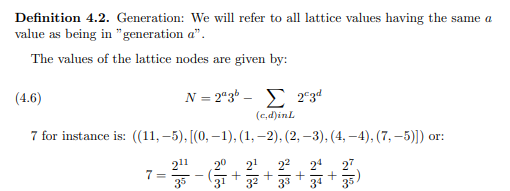

In [82]:
def gen_generation(a):
    """ Generate a (label, a_b_c_tuple, numerator_denominator_pair) tuple for each
        lattice node in a generation

        Note: uses what we have learned regarding the mapping of the label string
        to create a nodes L subtractand list -- does not require applying F_0, F_1

        Fastest way to generate a generation's nodes
    """
    seqs = product('10', repeat=a)
    for bits in seqs:
        label = ''.join(bits)
        zeros = [i for i, b in enumerate(bits) if b == '0']
        b = len(zeros)
        # compute c = sum_{j=0}^{k} 3^{k-j} * 2^{i_j - 1}
        c = sum((3 ** (b - j - 1)) * (2 ** (i)) for j, i in enumerate(zeros))
        f = Fraction(2**a - c, 3**b)
        yield (label, (a,b,c), (f.numerator, f.denominator))
#

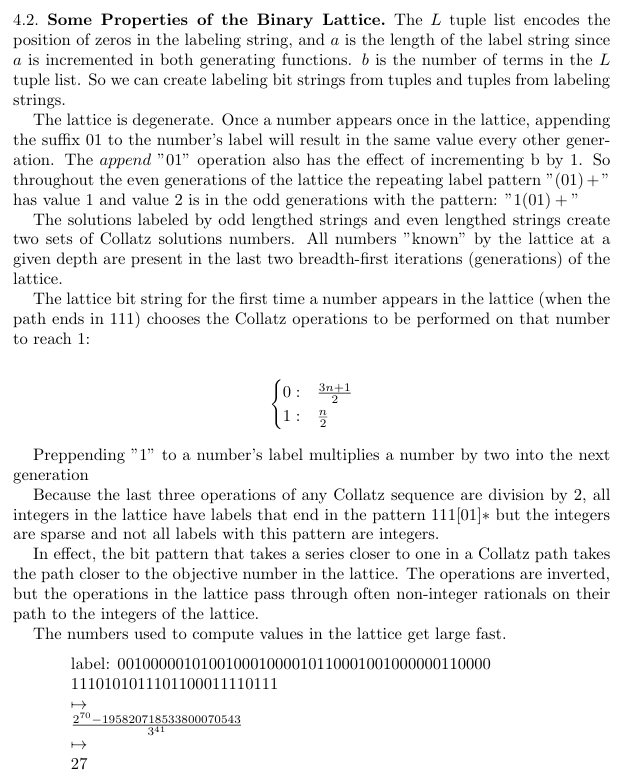

In [83]:
collatzPath(23)

'00011110111'

In [84]:
mrTupValue(mrTupFromPath("1" + collatzPath(23)))

(46, 1)

## Some additional properties not given in the paper

### 1 Composition Options
Some ways the number 1 can appear in the lattice

$ \Large{ \frac{2^{0}}{3^{0}} }$

$ \Large{ \frac{2^{2}}{3^{1}} - (   \frac{2^{0}}{3^{1}} ) }$

$ \Large{ \frac{2^{4}}{3^{2}} - (   \frac{2^{0}}{3^{1}} + \frac{2^{2}}{3^{2}} )  }$

$ \Large{ \frac{2^{6}}{3^{3}} - (   \frac{2^{0}}{3^{1}} + \frac{2^{2}}{3^{2}} + \frac{2^{4}}{3^{3}} )  }$

$ \Large{ \frac{2^{8}}{3^{4}} - (   \frac{2^{0}}{3^{1}} + \frac{2^{2}}{3^{2}} + \frac{2^{4}}{3^{3}} + \frac{2^{6}}{3^{4}} )  }$

$ \Large{ \frac{2^{10}}{3^{5}} - (   \frac{2^{0}}{3^{1}} + \frac{2^{2}}{3^{2}} + \frac{2^{4}}{3^{3}} + \frac{2^{6}}{3^{4}} + \frac{2^{8}}{3^{5}} )  }$

$ \Large{ \frac{2^{12}}{3^{6}} - (   \frac{2^{0}}{3^{1}} + \frac{2^{2}}{3^{2}} + \frac{2^{4}}{3^{3}} + \frac{2^{6}}{3^{4}} + \frac{2^{8}}{3^{5}} + \frac{2^{10}}{3^{6}} )  }$

$ \Large{ \frac{2^{14}}{3^{7}} - (   \frac{2^{0}}{3^{1}} + \frac{2^{2}}{3^{2}} + \frac{2^{4}}{3^{3}} + \frac{2^{6}}{3^{4}} + \frac{2^{8}}{3^{5}} + \frac{2^{10}}{3^{6}} + \frac{2^{12}}{3^{7}} )  }$

### Some Power series found in the lattice
- 0[11]+ labels are $n' = 4n+1$ numbers, $n_0 = 0$
- 10[11]+ labels are $n' = 4n+2$ numbers, $n_0 = 0$

In [85]:
# https://oeis.org/A072197 
#  a(n) = 4*a(n-1) + 1 with a(0) = 3.
def oeis_A072197():
    n = 3
    for i in range(8):
        label = collatzPath(n)
        print(f"{n}: {label}")
        n = 4*n + 1
#
oeis_A072197()

3: 00111
13: 0110111
53: 011110111
213: 01111110111
853: 0111111110111
3413: 011111111110111
13653: 01111111111110111
54613: 0111111111111110111


### When we swap '110' for '011' WE ALWAYS GET 1 even from rationals

$$
F_{tail}(F_0(F_1(F_1(N_{\emptyset})))) -1 = F_{tail}(F_1(F_1(F_0(N_{\emptyset})))) 
$$
$$
F_0(F_1(F_1(N_{\emptyset}))) -1 = F_1(F_1(F_0(N_{\emptyset})))
$$
$$
V(T_{011}) -1 = V(T_{110})
$$
$$ \frac{7}{3} - 1 = \frac{4}{3} $$

So the # $4\pmod{8}$ ("110") integers are 1:1 to $5\pmod{8}$ ("011") integers and have identical integer production rates in the lattice.


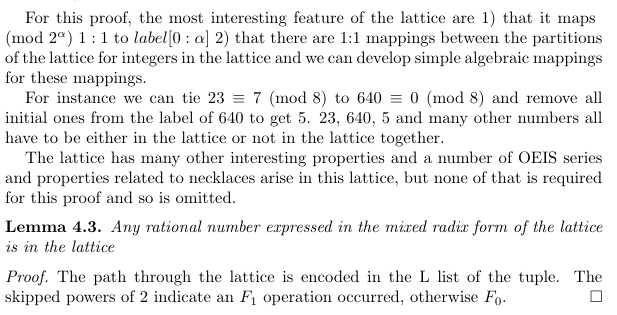

In [86]:
collatzPath(23)

'00011110111'

In [87]:
# mrTupFromPath gives us mix radix Tuples from a label
T_23 = mrTupFromPath('00011110111')
T_23

((11, -4), [(0, -1), (1, -2), (2, -3), (7, -4)])

In [88]:
mrTupToLaTex(T_23)

'$ \\frac{2^{11}}{3^{4}} - (   \\frac{2^{0}}{3^{1}} + \\frac{2^{1}}{3^{2}} + \\frac{2^{2}}{3^{3}} + \\frac{2^{7}}{3^{4}} ) $'

# Mapping from label to tuple to mixed radix form

$$
\text{"00011110111"}
$$
$$
\mapsto
$$ 
$$
((11, -4), [(0, -1), (1, -2), (2, -3), (7, -4)])
$$
$$
\mapsto
$$
$$ 
\frac{2^{11}}{3^{4}} - (   \frac{2^{0}}{3^{1}} + \frac{2^{1}}{3^{2}} + \frac{2^{2}}{3^{3}} + \frac{2^{7}}{3^{4}} ) 
$$

| Description | Label | Tuple | Mixed Radix |
| ---: | --: | --- | --- |
| label length | 11     | ((11,   | $2^{11}$ |
| label zeros | 4 | -4), | $3^{-4}$ |
| $0_0$ | "0 | (0, -1) | $\frac{2^{0}}{3^{1}}$ |
| $0_1$ | 0 | (1, -2) | $\frac{2^{1}}{3^{2}}$ |
| $0_2$ | 0 | (2, -3) | $\frac{2^{2}}{3^{3}}$ | 
| $1_3,1_4,1_5,1_6$ | 1111 | | |
| $0_7$ | 0 | (7, -4)) | $\frac{2^{7}}{3^{4}}$ |
| integer suffix | 111" | | |


## Observation:
As we increase the partitioning of the lattice, the difference in path lengths between the top and bottom of the lattice grows.  Turns out that this is a necessary feature of the lattice for this proof.

# Operations In the Lattice

This section became superlous to the proof and so was dropped from the paper.  But the Neighborly 2n+1 algorithm was the real beginning of the solution to the conjecture.

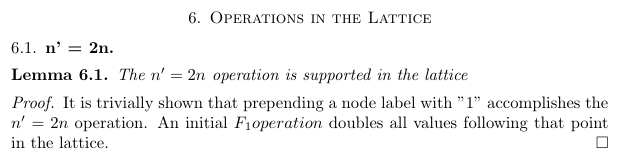

In [89]:
collatzPath(7)

'00010110111'

In [90]:
T_14 = mrTupFromPath('1' + '00010110111')
mrTupValue(T_14)

(14, 1)

In [91]:
def mr2Nplus_1(T):
    B = len(T[1])  
    L = [(0, -1)]

    # Keep initial zeros
    idx = 0
    for idx, val in enumerate(T[1]):
        if T[1][idx][0] != idx:
            break
        L.append( (T[1][idx][0] + 1, T[1][idx][1]-1) )
    # Remove the first tuple where (a, -a) is true
    match = False
    for i in range(idx, B, 1):
        if (not match) and (T[1][i][0] == -T[1][i][1]):
            match = True
        else:
            L.append( (T[1][i][0]+1, T[1][i][1]) )
    if not match:
        return None
    return ( (T[0][0] + 1, T[0][1]), L)
#


# Neighborly 2n+1

It was the discovery of this function and my attempts to squeeze a proof out of knowledge about 3/4's of integers that lead to the more powerful modulus features of the lattice.  This function wound up not being necessary for the proof, but was a major way point in getting there.

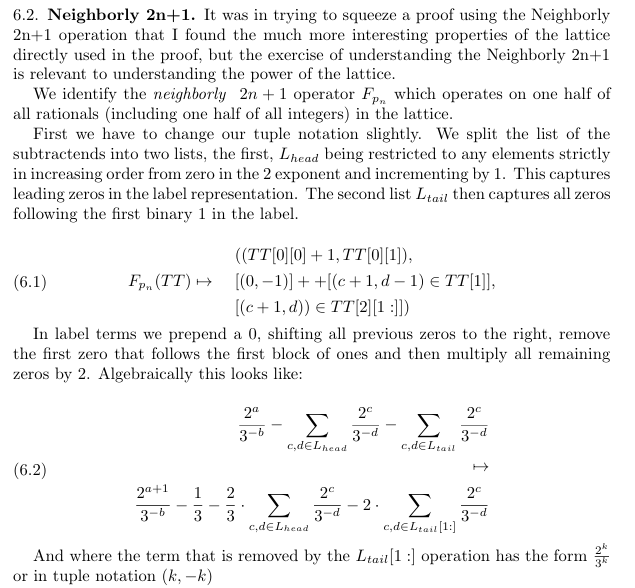

In [92]:
collatzPath(7)

'00010110111'

In [93]:
T = mrTupFromValue(7)
T

((11, -5), [(0, -1), (1, -2), (2, -3), (4, -4), (7, -5)])

In [94]:
T_2p1 = mr2Nplus_1(T)
T_2p1

((12, -5), [(0, -1), (1, -2), (2, -3), (3, -4), (8, -5)])

In [95]:
mrTupValue(T_2p1)  # Gives 2*7 + 1

(15, 1)

In [96]:
collatzPath(15)

'000011110111'

In [97]:
label_3p1 = collatzPath(3*7 + 1)

In [98]:
T_3p1 = mrTupFromPath(label_3p1)
T_3p1

((11, -4), [(1, -1), (2, -2), (4, -3), (7, -4)])

In [99]:
comment_2np1 = """
 00010110111 :  7
!    ^
000011110111 : 15

 00010110111 :  7
 ^
 10010110111 : 22
"""

In [100]:
def mrTupToLaTex(T):
    a, b = T[0]
    s = "\\frac{2^{%d}}{3^{%d}}"%(a, -b)
    L = T[1]
    if len(L) > 0:
        s = s + " - ( "
        plus = "  "
        for c_d in L:
            c, d = c_d
            t = "\\frac{2^{%d}}{3^{%d}}"%(c, -d)
            s = s + plus + t
            plus = " + "
        s = s + " )"
    return "$ " + s + " $"
#

## Comments on why neighborly 2n+1 works

- 3n+1 always changes odds to evens and evens to odds
    - 3n+1 is one of the diophantine transforms found later ("011" -> "111") but is available as an operation the lattice more than this mapping case.
- 2n+1 always produces an odd

### Odd numbers

We have:

- 7 is 00010110111:

$ T_{7} = \frac{2^{11}}{3^{5}} - (   \frac{2^{0}}{3^{1}} + \frac{2^{1}}{3^{2}} + \frac{2^{2}}{3^{3}} + $<span style="color: red;">$\frac{2^{4}}{3^{4}}$</span>$ + \frac{2^{7}}{3^{5}} ) $

- 15 is 000011110111:

$ T_{15} = \frac{2^{12}}{3^{5}} - (   $<span style="color: green;">$\frac{2^{0}}{3^{1}}$</span>$ + \frac{2^{1}}{3^{2}} + \frac{2^{2}}{3^{3}} + \frac{2^{3}}{3^{4}} + \frac{2^{8}}{3^{5}} )$ 

    - Addend power of 2 increased, new first-term added to subtractend and all other subtractend term powers of three reduced

- 22 is 10010110111:

$ T_{22} = \frac{2^{11}}{3^{4}} - (   \frac{2^{1}}{3^{1}} + \frac{2^{2}}{3^{2}} + \frac{2^{4}}{3^{3}} + \frac{2^{7}}{3^{4}} ) $ 

    - Power of 3 increased in addend and all powers of 2 increased in subractend

For odd numbers when $\frac{2^{0}}{3^{1}}$ is available to be removed from the subtractend to give a minimal label length for 3n+1 and there is at least one other subtractend term following a gap in the zeros (so it will have the \frac{2^b}{3^b} term with the same exponential in the numerator and denominator), then the neighborly 2n+1 works. 

$$
2n+1 = 3(\frac{2}{3}n + \frac{1}{3})
$$

### Even numbers

- 14 is 100010110111:

$ T_14 =  \frac{2^{12}}{3^{5}} - (   \frac{2^{1}}{3^{1}} + \frac{2^{2}}{3^{2}} + \frac{2^{3}}{3^{3}} + \frac{2^{5}}{3^{4}} + \frac{2^{8}}{3^{5}} ) $

- 29 is 0110010110111:

$ T_{29} = \frac{2^{13}}{3^{5}} - (   \frac{2^{0}}{3^{1}} + \frac{2^{3}}{3^{2}} + \frac{2^{4}}{3^{3}} + \frac{2^{6}}{3^{4}} + \frac{2^{9}}{3^{5}} ) $

- 43 is 00101011100010110111

$ T_{43} =  \frac{2^{20}}{3^{9}} - (   \frac{2^{0}}{3^{1}} + \frac{2^{1}}{3^{2}} + \frac{2^{3}}{3^{3}} + \frac{2^{5}}{3^{4}} + \frac{2^{9}}{3^{5}} + \frac{2^{10}}{3^{6}} + \frac{2^{11}}{3^{7}} + \frac{2^{13}}{3^{8}} + \frac{2^{16}}{3^{9}} ) $

So clearly 3n+1 has nothing to do with even numbers.  In the even case 2n+1 functions directl

$$
2n+1 = 2(n +\frac{2}{3}) - \frac{1}{3}
$$

### Coincidence?

The remove, shift, insert-front operation works for different reasons for odd and even numbers, but works none-the-less.


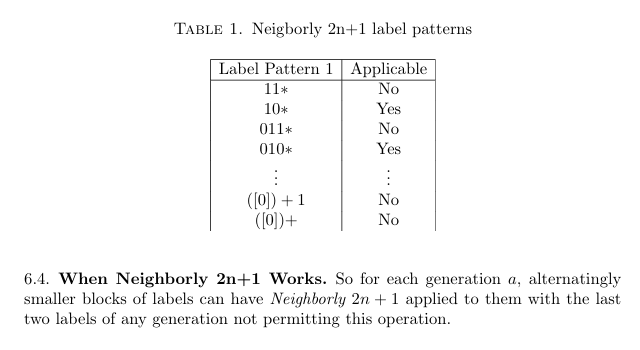

In [101]:
# TODO

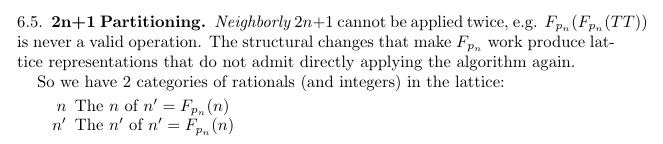

# MOD 8 and Neighborly 2n+1

- The lattice at any given generation is almost evenly divided into $2n+1$ *neighborly* and *non-neighborly* partitions based on the label
- The integer partitioning $\pmod{8}$ with respect to neighborlyness are not quite so evenly distributed -- only 3/8ths of all integers are neighborly:

| MOD 8 | Partition | Peer | $2n+1$ | $\frac{n-1}{2}$ | Comment |
| --- | --- | --- | --- |--- | --- |
| 0 | non-neighborly | N/A | $1 \pmod{8}$ : neighborly| __non-integer__ | $N \equiv 0 \pmod{4}$  |
| 1 | neighborly  | $2n+1$ | $3 \pmod{16}$ : non-neighborly<br/> $11 \pmod{16}$ : neighborly<br/>| $0 \pmod{8}$ <br> $4 \pmod{8}$|  |
| 2 | neighborly  | $2n+1$ | $5 \pmod{8}$ : non-neighborly | (non-integer) | $N \equiv 2 \pmod{4}$ |
| 3 | non-neighborly | $\frac{n-1}{2}$ <br>None | $7 \pmod{8}$ : neighborly | $1 \pmod{8}$ : neighborly <br> $5 \pmod{8}  $ : non-neighborly | $N \equiv 3 \pmod{4}$ , $2(2n+1) + 1 = 4n+3$|
| 4 | non-neighborly  | N/A |  $1 \pmod{8}$ : neighborly |   __non-integer__  | $N \equiv 0 \pmod{4}$ |
| 5 | non-neighborly  | $\frac{n-1}{2}$  | $2 \pmod{8}$ : neighborly |  PEER $2 \lor 6  \pmod{8}$:  neighborly  |  |
| 6 | neighborly  | $2n+1$ | $5 \pmod{8}$ : non-neighborly|   (non-integer)   | $N \equiv 2 \pmod{4}$ |
| 7 | EITHER | Mix | __SELF__ | __SELF__  | $N \equiv 3 \pmod{4}$ , $2(2n+1) + 1 = 4n+3$|

So the lattice generates neighborly numbers faster than than their overall occurence as a simple paritioning of the integers.  This will be because the magnitude of non-neighborly numbers (e.g. $2^n$) grow faster at the top of the lattice and so wind up being spread out across more generations.

## $7 \pmod{8}$ Result is interesting

Looks like half of all $7 \pmod{8}$ are neighborly or non-neighborly, but they are not patitioned by $\pmod{16}$

## $3 \pmod{8}$ Result is unexpected

This breaks my earlier belief that all integers had a $n' -> 2n+1$ *neighborly* peer.  Half of all $3 \pmod{8}$ (even though odd) do not have an easy-to-find $\frac{(3 \pmod{8})-1}{2}$ nieghborly peer. 

The similarities and differences between $3 \pmod{8}$ and $7 \pmod{8}$ are also notable since both are related to  $3 \pmod{4}$ which is the result of applying $n' =2n+1$ twice.

## $0 \pmod{8}, 4 \pmod{8}$ Results should have been expected.  

These numbers being even and non-neighborly could never have a neighborly 2n+1 preceding peer integer.  Some (All?) of these non-integers are probably non-lattice.

In general, the 2n+1 operation does not provide the clean partitioning I thought it did where we would always find pairs of neighborly and non-neighborly numbers.

But other facts of the partitioning hold:  

-  At a given generation, the lattice is nearly evenly divided between neighborly ($2^{a-1} - 1$ nodes) and non-neighborly ($2^{a-1} + 1$ nodes) rationals/integers
-  3/8 of all integers are neighborly, neighborly numbers always have a peer non-neighborly number
-  5/8 of all integers are non-neighborly
    -  3 out of 10 of these numbers have an easily found reverse mapping to a preceding 2n+1 number
- 9/16 of all integers have a peer (e.g. are either $n$ or $n'$ in $n' = 2n+1$ and their peer is the other number) under the **neighborly $2n+1$** operation

In [102]:
# TODO: ^^^ Update this

# Legarius 1985

But he referred to the idea coming from Terras

## mod_2^n and first parity bits of the Shortcut Collatz Conjecture

If a pair of numbers have the same first k parity bits under the Shortcut Collatz Conjecture, then they are $\pmod{2^k}$ congruent.

##

inrtoduce some notation to describe the results of the process of iterating the function $T(n)$.  Given an integer $n$, define a sequence of $0-1$ valued quantities $x_i(n) by

$$
(2.2) \quad T^{(i)}(n) = x_i(n) (mod 2), \quad 0 \le i \le \infty
$$
$$
\text{ where } \quad T^{(0)}(n) = n.
$$

The results of the first k iterations of T are completely described by the parity vector

$$
(2.3) \quad v_k(n) = (x_0(n), \dots, x_{k-1}(n))
$$

Since the result of k iterations is:

$$
(2.4) \quad T^{(k)}(n) = \lambda_k(n)n + \rho_k(n)
$$
$$
\text{ where }
$$
$$
(2.5) \quad \lambda_k(n) = {\Large\frac{3^{x_0(n)+ \dots + x_{k-1}(n)}}{2^{k}}}
$$
$$
\text{ and }
$$
$$
(2.6) \quad \rho_k(n) = \sum_{i=0}^{k-1}\Large{X_i(n)\frac{3^{ x_{i+1}(n)  + \dots + x_{k-i}(n) }}{2^{k-i}}}
$$

Note that in (2.5), (2.6) both $\lambda_k$ and $\rho_k$ are completely determined by the parity vector $v=v_k(n)$ given by 2.3; I sometimes indicate this by writing $\lambda_k(v), \ \rho_k(v) (instead of \lambda+k(n), \rho_k(n)). The formula (2.4) shows that a neccessary condition for T^{(k)}(n) is that

$$
(2.7) \quad \lambda_k(n) < 1
$$
Since $\rho_k(n)$ is nonnegative.  Terras [64] defines the \emph{coefficient stopping time} $\omega(n)$ to be the least value of $k$ such that (2.7) holds and $+\infty$ if no such value of $k$ exists.  It is immediate that
$$
(2.8) \quad \omega(n) \le \sigma(n)
$$
The function $\omega(n)$ plays an important role in the analysis of the behavior of the stopping time function $\sigma(n)$, see Theorem C

The formula (2.2) expresses the parity vector v=v_k(n) as a function of n.  Terra's idea is to reverse this process and express n as a function of v.



### Theorem B.

The function $Q_k: \mathbb{Z} \mapsto \mathbb{Z}/2^k\mathbb{Z} \quad$  defined by

$$
Q_k(n) = \sum_{i=0}^{k-1}x_i(n)2^i
$$

is periodic with period $2^k$.  The induced function $\bar{Q}_k: \mathbb{Z}/2^k\mathbb{Z} \mapsto \mathbb{Z}/2^k\mathbb{Z}$ is a permutation, and its order is a power of 2.  

### Proof (sketch)
The theorem is etablished by induction on k, using the inductive hypothesises:

- (1) $\quad x_i(n)$ is periodic with period $2^{i+1} \quad$ for $\quad 0 \lt i \lt k-1$.
In fact

$$
(2.9) \quad x_i(n + 2^1) \equiv x_i(n) + 1 (mod 2)
$$
$$
\text{for }\quad 0 \le i \le k -1
$$

- (2) $Q_k(n)$ is periodic with period $2^k$
- 
- (3) $\lambda_k(n) \ \  and \ \  \rho_k(n)$ are periodic with period $2^k$
- 
- (4) $\bar{Q}_k$ is a permutation whose order divides $2^k$.  Also:

$$
(2.10) \quad \bar{Q}_k(n + 2^{k-1}) \equiv \bar{Q}_k(n) + 2^{k-1} \pmod{2^k}
$$



# Full Induction Proof for (2.10)

I iterated with Gemini to generate this proof as an exercise in re-educating myself on induction.  I chose this specific equation because of its relevance to the paper and to take his sketch and deepen my understanding of the fundamentals behind it.  I believe this is correct, but would love to hear what is wrong with it if it is not correct.  But I assume that I can take the original assertion from 1985 as fact at this point.


The goal is to provide the full induction proof for Legarius's Equation (2.10)

The equation to be proven is:
$$(2.10) \quad \bar{Q}_k(n + 2^{k-1}) \equiv \bar{Q}_k(n) + 2^{k-1} \pmod{2^k}$$

Here, $\bar{Q}_k(n)$ is the unique integer in the set $\{0, 1, \dots, 2^k - 1\}$ that generates the same parity vector $v_k(n) = (x_0(n), \dots, x_{k-1}(n))$ as $n$.

---

### Base Case: $k=1$

For $k=1$, the equation becomes:
$$\bar{Q}_1(n + 2^{1-1}) \equiv \bar{Q}_1(n) + 2^{1-1} \pmod{2^1}$$
$$\bar{Q}_1(n + 1) \equiv \bar{Q}_1(n) + 1 \pmod{2}$$

The function $\bar{Q}_1(n)$ represents $n \pmod 2$.

* If $n$ is **even** ($n \equiv 0 \pmod 2$):
    $\bar{Q}_1(n) = 0$. $n+1$ is odd, so $\bar{Q}_1(n+1) = 1$.
    Equation: $1 \equiv 0 + 1 \pmod 2$. (True)
* If $n$ is **odd** ($n \equiv 1 \pmod 2$):
    $\bar{Q}_1(n) = 1$. $n+1$ is even, so $\bar{Q}_1(n+1) = 0$.
    Equation: $0 \equiv 1 + 1 \pmod 2$, since $0 \equiv 2 \pmod 2$. (True)

The base case holds.

---

### Inductive Hypothesis

Assume that the statement holds for some $k \ge 1$:
$$ (IH) \quad \bar{Q}_k(n + 2^{k-1}) \equiv \bar{Q}_k(n) + 2^{k-1} \pmod{2^k}$$

---

### Inductive Step: Prove for $k+1$

We want to show that the equation holds for $k+1$:
$$\bar{Q}_{k+1}(n + 2^{(k+1)-1}) \equiv \bar{Q}_{k+1}(n) + 2^{(k+1)-1} \pmod{2^{k+1}}$$
$$\bar{Q}_{k+1}(n + 2^k) \equiv \bar{Q}_{k+1}(n) + 2^k \pmod{2^{k+1}}$$

The key relationship between the $\bar{Q}_{k+1}$ residue class and the $\bar{Q}_k$ class is given by the definition of the reduced residue system:
$$\bar{Q}_{k+1}(n) = \bar{Q}_k(n) + x_k(n) \cdot 2^k$$
where $x_k(n) = T^{(k)}(n) \pmod 2$ is the $(k+1)$-th parity bit.

Substitute this relation into the left and right sides of the goal equation:

$$ \bar{Q}_k(n + 2^k) + x_k(n + 2^k) \cdot 2^k \equiv \left( \bar{Q}_k(n) + x_k(n) \cdot 2^k \right) + 2^k \pmod{2^{k+1}}$$

To prove this, we rely on two established auxiliary properties (Lemma 2.3 in the original paper) which are consequences of (2.4)-(2.6):

1.  **Residue Invariance Modulo $2^k$**: Adding $2^k$ to $n$ does not change its $\bar{Q}_k$ representative:
    $$\bar{Q}_k(n + 2^k) = \bar{Q}_k(n)$$
    *Proof sketch: $n+2^k \equiv n \pmod{2^k}$. Since the reduced residue system $\bar{Q}_k$ is unique modulo $2^k$, and $v_k(n+2^k) = v_k(n)$, their representatives must be equal.*

2.  **Parity Flip Property**: Adding $2^k$ to $n$ flips the $(k+1)$-th parity bit:
    $$x_k(n + 2^k) \equiv x_k(n) + 1 \pmod 2$$
    *Proof sketch: $T^{(k)}(n+2^k) = T^{(k)}(n) + \lambda_k(n) 2^k$. Since $\lambda_k(n) = 3^s / 2^k$ (from (2.5)) where $s$ is the number of odd steps, and $s$ is odd/even depending on $v_k$, this congruence simplifies to $T^{(k)}(n+2^k) \equiv T^{(k)}(n) + 1 \pmod 2$.*

Substitute these two properties into the congruence:

$$ \underbrace{\bar{Q}_k(n + 2^k)}_{=\bar{Q}_k(n)} + \underbrace{x_k(n + 2^k)}_{\equiv x_k(n) + 1 \pmod 2} \cdot 2^k \equiv \bar{Q}_k(n) + x_k(n) \cdot 2^k + 2^k \pmod{2^{k+1}}$$

Since $x_k(n + 2^k)$ is either $x_k(n) + 1$ or $x_k(n) - 1$ (both are congruent $\pmod 2$), we write:
$$ \bar{Q}_k(n) + (x_k(n) + 1) \cdot 2^k \equiv \bar{Q}_k(n) + x_k(n) \cdot 2^k + 2^k \pmod{2^{k+1}}$$

Expanding the left side:
$$ \bar{Q}_k(n) + x_k(n) \cdot 2^k + 2^k \equiv \bar{Q}_k(n) + x_k(n) \cdot 2^k + 2^k \pmod{2^{k+1}}$$

This is an identity. Subtracting the common terms from both sides results in:
$$ 0 \equiv 0 \pmod{2^{k+1}}$$

The statement holds for $k+1$. By the principle of mathematical induction, Equation (2.10) is proven.

### Mapping 2.10 to the lattice

- Legarius' $v_k$ is my label string and the $X(i) = x_i$ it contains are my label bits (with 0,1 swapped).
- Legarius' $\bar{Q}_k$ is the rational in the lattice that has label of length k that matches the first k label bits of the label of n
    - The $v_k$ of $\bar{Q}_k$ is 1:1 with a lattice label prefix of length $k$
    - If we limit the lattice values under consideration to the integers, then the relationship between the lattice path and the $\pmod{2^k}$ classes is exactly the same as that found by Legarius.




| Feature | Lagarias $v_k(n)$ |Lattice Label |
| ---:  | :--- | :--- |
| Indexing Start | $x_0(n)$ (Parity of n) | Index 0 (First Inverse Step)|
| Indexing End | $x_{k−1}(n) (Parity of C(k−1)(n)) | Index k−1 (Last Inverse Step)
| Direction | Forward Collatz Path | Inverse Collatz Path|

### Note: 
    - that 2.4,2.5,2.6 is similar-to but upside down from my original (a, b, c) tuple representation of the lattice
    - Theorem C is not relevant to this paper, just Theorem B


In [103]:
def shortParity(k, n):
    parity_bits = []
    for i in range(k):
        if n == 1:  
            return None
        n_ = C(n)
        if n_ < n:
            parity_bits.append("0")
        else:
            parity_bits.append("1")
        n = n_
    return "".join(parity_bits)
# 
def verifyShortParityMod(k, test_count=2**10):
    mod_base = 2**k
            
    # generate 2^a slots for modulus mappings
    mapping = [""]*(mod_base)
    for i in range(mod_base, test_count+mod_base): # made sure starting label isn't shorter than test target length
        mod = i % mod_base
        parity_str = shortParity(k, i)
        if parity_str is not None:  # A number was given that has a shorter path than k
            if len(mapping[mod]) > 0:
                if parity_str != mapping[mod]:
                    print("Non-unique label map!")
            else:
                # First time
                mapping[mod] = parity_str
#

In [104]:
# No output == good
verifyShortParityMod(3)

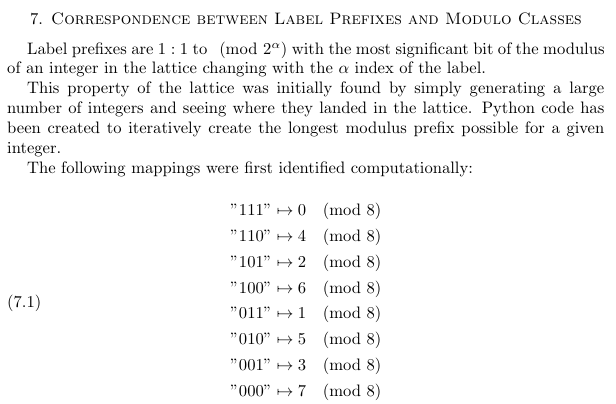

In [105]:
def verifyUniqueMapping(prefix_length, test_count=2**10):
    mod_base = 2**prefix_length
            
    # generate 2^a slots for modulus mappings
    mapping = [""]*(mod_base)
    for i in range(mod_base, test_count+mod_base): # made sure starting label isn't shorter than test target length
        mod = i % mod_base
        label = collatzPath(i)
        if len(mapping[mod]) > 0:
            if label[0:prefix_length] != mapping[mod]:
                print("Non-unique label map!")
        else:
            # First time
            mapping[mod] = label[0:prefix_length]
#
verifyUniqueMapping(3)

In [106]:
# No output => No errors.
verifyUniqueMapping(6)

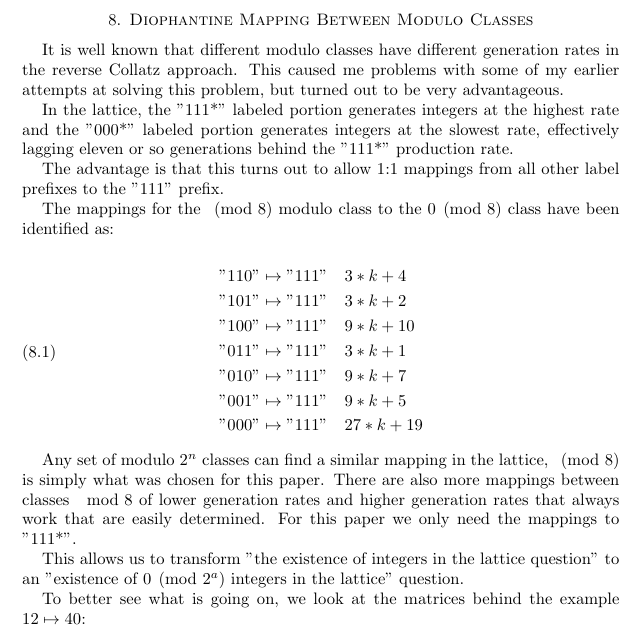

In [107]:
# Put the code here that I used to find all the 1:1 mappings

In [108]:
solve_Ay_L(collatzPath(20))

(array([[-1.,  2.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0., -1.,  2.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0., -3.,  2.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0., -1.,  2.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0., -1.,  2.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0., -1.,  2.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0., -3.,  2.],
        [ 0.,  0.,  0.,  0.,  0.,  1.,  0., -1.]]),
 array([20., 10.,  5.,  8.,  4.,  2.,  1.,  2.]),
 array([0., 0., 1., 0., 0., 0., 1., 0.]))

$$
\begin{bmatrix}
\mathbf{-1} & \mathbf{2} & 0 & 0 & 0 & 0 & 0 & 0 & 0 \\\\
0 & \mathbf{-1} & \mathbf{2} & 0 & 0 & 0 & 0 & 0 & 0 \\\\
0 & 0 & \mathbf{-3} & \mathbf{2} & 0 & 0 & 0 & 0 & 0 \\\\
0 & 0 & 0 & -3 & 2 & 0 & 0 & 0 & 0 \\\\
0 & 0 & 0 & 0 & -1 & 2 & 0 & 0 & 0 \\\\
0 & 0 & 0 & 0 & 0 & -1 & 2 & 0 & 0 \\\\
0 & 0 & 0 & 0 & 0 & 0 & -1 & 2 & 0 \\\\
0 & 0 & 0 & 0 & 0 & 0 & 0 & -3 & 2 \\\\
0 & 0 & 0 & 0 & 0 & 0 & 1 & 0 & -1
\end{bmatrix}
\begin{bmatrix}
12 \\\\
6 \\\\
3 \\\\
5 \\\\
8 \\\\
4 \\\\
2 \\\\
1 \\\\
2
\end{bmatrix}
=
\begin{bmatrix}
\mathbf{0} \\\\
\mathbf{0} \\\\
\mathbf{1} \\\\
1 \\\\
0 \\\\
0 \\\\
0 \\\\
1 \\\\
0
\end{bmatrix}
$$

In [109]:
solve_Ay_L(collatzPath(3*12 + 4))

(array([[-1.,  2.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0., -1.,  2.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0., -1.,  2.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0., -3.,  2.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0., -1.,  2.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0., -1.,  2.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0., -1.,  2.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0., -3.,  2.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  1.,  0., -1.]]),
 array([40., 20., 10.,  5.,  8.,  4.,  2.,  1.,  2.]),
 array([0., 0., 0., 1., 0., 0., 0., 1., 0.]))

$$
\begin{bmatrix}
\mathbf{-1} & \mathbf{2} & 0 & 0 & 0 & 0 & 0 & 0 & 0 \\\\
0 & \mathbf{-1} & \mathbf{2} & 0 & 0 & 0 & 0 & 0 & 0 \\\\
0 & 0 & \mathbf{-1} & \mathbf{2} & 0 & 0 & 0 & 0 & 0 \\\\
0 & 0 & 0 & -3 & 2 & 0 & 0 & 0 & 0 \\\\
0 & 0 & 0 & 0 & -1 & 2 & 0 & 0 & 0 \\\\
0 & 0 & 0 & 0 & 0 & -1 & 2 & 0 & 0 \\\\
0 & 0 & 0 & 0 & 0 & 0 & -1 & 2 & 0 \\\\
0 & 0 & 0 & 0 & 0 & 0 & 0 & -3 & 2 \\\\
0 & 0 & 0 & 0 & 0 & 0 & 1 & 0 & -1
\end{bmatrix}
\begin{bmatrix}
40 \\\\
20 \\\\
10 \\\\
5 \\\\
8 \\\\
4 \\\\
2 \\\\
1 \\\\
2
\end{bmatrix}
=
\begin{bmatrix}
\mathbf{0} \\\\
\mathbf{0} \\\\
\mathbf{0} \\\\
1 \\\\
0 \\\\
0 \\\\
0 \\\\
1 \\\\
0
\end{bmatrix}
$$

In [110]:
mrTupValue(mrTupFromPath("11111110111"))

(640, 1)

In [111]:
mrTupValue(mrTupFromPath("0111"))

(5, 1)

In [112]:
collatzPath(3)

'00111'

In [113]:
solve_Ay_L(collatzPath(3))

(array([[-3.,  2.,  0.,  0.,  0.,  0.,  0.],
        [ 0., -3.,  2.,  0.,  0.,  0.,  0.],
        [ 0.,  0., -1.,  2.,  0.,  0.,  0.],
        [ 0.,  0.,  0., -1.,  2.,  0.,  0.],
        [ 0.,  0.,  0.,  0., -1.,  2.,  0.],
        [ 0.,  0.,  0.,  0.,  0., -3.,  2.],
        [ 0.,  0.,  0.,  0.,  1.,  0., -1.]]),
 array([3., 5., 8., 4., 2., 1., 2.]),
 array([1., 1., 0., 0., 0., 1., 0.]))

In [114]:
collatzVector(12)

array([12,  6,  3,  5,  8,  4,  2,  1,  2])

In [115]:
A, y = Ay_L(collatzPath(12))
np.dot(A, collatzVector(12)), y

(array([0., 0., 1., 1., 0., 0., 0., 1., 0.]),
 array([0., 0., 1., 1., 0., 0., 0., 1., 0.]))

In [116]:
collatzPath(12)

'1100111'

In [117]:
collatzPath(3*12 + 4)

'1110111'

In [118]:
solve_Ay_L(collatzPath(20))

(array([[-1.,  2.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0., -1.,  2.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0., -3.,  2.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0., -1.,  2.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0., -1.,  2.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0., -1.,  2.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0., -3.,  2.],
        [ 0.,  0.,  0.,  0.,  0.,  1.,  0., -1.]]),
 array([20., 10.,  5.,  8.,  4.,  2.,  1.,  2.]),
 array([0., 0., 1., 0., 0., 0., 1., 0.]))

In [119]:
solve_Ay_L(collatzPath(64))

(array([[-1.,  2.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0., -1.,  2.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0., -1.,  2.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0., -1.,  2.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0., -1.,  2.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0., -1.,  2.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0., -3.,  2.],
        [ 0.,  0.,  0.,  0.,  0.,  1.,  0., -1.]]),
 array([64., 32., 16.,  8.,  4.,  2.,  1.,  2.]),
 array([0., 0., 0., 0., 0., 0., 1., 0.]))

In [120]:
solve_Ay_L(collatzPath(3*12 + 4))

(array([[-1.,  2.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0., -1.,  2.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0., -1.,  2.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0., -3.,  2.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0., -1.,  2.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0., -1.,  2.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0., -1.,  2.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0., -3.,  2.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  1.,  0., -1.]]),
 array([40., 20., 10.,  5.,  8.,  4.,  2.,  1.,  2.]),
 array([0., 0., 0., 1., 0., 0., 0., 1., 0.]))

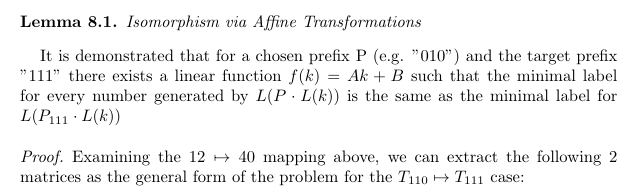

$$
\begin{array}{cc}
	\begin{bmatrix}
		\mathbf{-1} & \mathbf{2} & 0  \\
		0 & \mathbf{-1} & \mathbf{2}  \\
		0 & 0 & \mathbf{-3}  \\
	\end{bmatrix}
	\begin{bmatrix}
		x_0 \\ x_1 \\ x_2
	\end{bmatrix}
	=
	\begin{bmatrix}
		\mathbf{0} \\ \mathbf{0} \\ z-1 
	\end{bmatrix}
	&
	\quad
	\begin{bmatrix}
		\mathbf{-1} & \mathbf{2} & 0 \\
		0 & \mathbf{-1} & \mathbf{2} \\
		0 & 0 & \mathbf{-1}  \\
	\end{bmatrix}
	\begin{bmatrix}
		x_0' \\ x_1' \\ x_2' 
	\end{bmatrix}
	=
	\begin{bmatrix}
		\mathbf{0} \\ \mathbf{0} \\ z 
	\end{bmatrix}
\end{array}
$$

$$
	\begin{aligned}
		& x_0 = -\frac{4z + 4}{3} \\
		& x_0' = -4z \\
		& x_0 = \frac{x_0' + 4}{3} \\
		& 3x_0 - 4= x_0' 
    \end{aligned}
$$


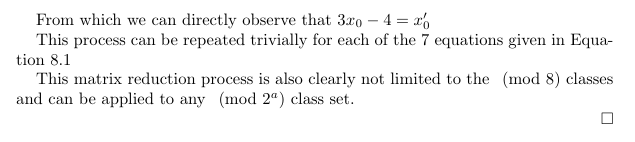

## The Full List of 3-bit Mappings that Always work 
Only the $\mapsto $ "111" were required for the proof

In [121]:
def T_010_to_T_111(k):  # 1(mod 8)
    return 9*k + 7
#
def T_010_to_T_110(k):
    return 3*k + 1
#
def T_010_to_T_011(k):
    return 3*k + 2
#
def T_101_to_T_111(k):
    return 3*k + 2
#
def T_001_to_T_111(k): # 3(mod 8)
    return 9*k + 5
#
def T_001_to_T_101(k):
    return 3*k + 1
#
def T_110_to_T_111(k):
    return 3*k + 4
#
def T_110_to_T_011(k):
    return k + 1
#
def T_011_to_T_111(k): # 5(mod 8)
    return 3*k + 1
#
def T_011_to_T_110(k):
    return k - 1
#
def T_011_to_T_100(k):
    # Not affine at 3 bits ...
    if (k%24) == 21:
        return (k//3) -1
    else:
        return k+2
#
def T_100_to_T_111(k):
    return 9*k + 10
#
def T_100_to_T_110(k):
    return 3*k + 2
#
def T_100_to_T_011(k):
    return 3*k + 3
#
def T_000_to_T_111(k):  # 7 (mod 8)
    return 27*k + 19
#
def T_000_to_T_110(k):
    return 9*k + 5
#
def T_000_to_T_011(k):
    return 9*k + 6
#
def T_000_to_T_100(k):
    return 3*k + 1
#

def checkMod8Formula(mod_8, tranform_func, prefix):
    for i in range(1000):
        k = 8*(i+2) + mod_8
        label = collatzPath(k)
        label_ = prefix + label[len(prefix):]
        val_ = mrTupValue(mrTupFromPath(label_))
        if val_[1] != 1:
            print(f"Label substitution FAILED {k}({label}) -> ({label_}) has noninteger {val_}")
            return False
        k_ = tranform_func(k) 
        if k_ != val_[0]:
            print(f"{tranform_func.__name__} FAILED {k} should -> {val_} but function gave {k_}")
            return False
    return True
#
[
    checkMod8Formula(1, T_010_to_T_111, "111"),
    checkMod8Formula(1, T_010_to_T_110, "110"),
    checkMod8Formula(1, T_010_to_T_011, "011"),
    
    checkMod8Formula(2, T_101_to_T_111, "111"),
    checkMod8Formula(3, T_001_to_T_111, "111"),
    
    checkMod8Formula(3, T_001_to_T_101, "101"),
    
    checkMod8Formula(4, T_110_to_T_111, "111"),
    checkMod8Formula(4, T_110_to_T_011, "011"),
    
    checkMod8Formula(5, T_011_to_T_111, "111"),
    checkMod8Formula(5, T_011_to_T_110, "110"),
    
    checkMod8Formula(6, T_100_to_T_111, "111"),
    checkMod8Formula(6, T_100_to_T_110, "110"),
    checkMod8Formula(6, T_100_to_T_011, "011"),
    
    checkMod8Formula(7, T_000_to_T_111, "111"),
    checkMod8Formula(7, T_000_to_T_110, "110"),
    checkMod8Formula(7, T_000_to_T_011, "011"),
    checkMod8Formula(7, T_000_to_T_100, "100")
]

[True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True]

### Symbolic Determinants of the non "111*" Matrices

A symbolic look at the numerator $Det(A_{x_0})$ matrices for the solution approach $x = \Large{\frac{Det(A_{x_0})}{Det(A)}}$

Where $ζ$ is $z-1$ when label bit is "0" or $z$ when label bit is "1"

In [122]:
from sympy import Matrix, MatrixSymbol, symbols
A = Matrix([[symbols('y0'), 2, 0], [symbols('y1'), symbols('b'), 2], [symbols('ζ'), 0, symbols('c')]])
det_A_0 = A.det()
det_A_0

b*c*y0 - 2*c*y1 + 4*ζ

In [123]:
A = Matrix([[symbols('y0'), 2, 0, 0], [symbols('y1'), symbols('b'), 2, 0], [symbols('y2'), 0, symbols('c'), 2], [symbols('ζ'), 0, 0, symbols('d')]])
det_A_0 = A.det()
det_A_0

b*c*d*y0 - 2*c*d*y1 + 4*d*y2 - 8*ζ

In [124]:
A = Matrix([
    [symbols('y0'), 2, 0, 0, 0], 
    [symbols('y1'), symbols('b'), 2, 0, 0], 
    [symbols('y2'), 0, symbols('c'), 2, 0], 
    [symbols('y3'), 0, 0, symbols('d'), 2],
    [symbols('ζ'), 0, 0, 0, symbols('e')]])
det_A_0 = A.det()
det_A_0

b*c*d*e*y0 - 2*c*d*e*y1 + 4*d*e*y2 - 8*e*y3 + 16*ζ

E.g. the pattern:
$$
terms =[ (-1)^0(y_0, b, c, d, e),  (-1)^1(2, y_1, c, d, e),  (-1)^2(2, 2, y_2, d, e),  (-1)^3(2, 2, 2, y_3, e), (-1)^4(2, 2, 2, 2, ζ) ]
$$
$$
    det(A_{x_0}) = \sum_{products}\prod_{terms}term
$$


- The determinant of $A_{111}$ is always  $-1^{rank}$
- The $x_0$ determinant of $A_{111,x_0}$ is always $2^{rank -1}$

So the $x_0$ equation for the "111" equation is always:

$x_0' = -1^{rank} \cdot 2^{rank -1}z$

- The determinant of $A$ is always $-1^{rank} \cdot 3^{zerocount}$
- The $x_0$ determinant of $A_{x_0}$ above is more complicated because of the ones that can appear in y.

# Generalize Isomorphic Transform

I have implemented the generalized form of the isomorphic transform for any $\pmod{2^a}$

This was not needed for the proof.

## The prefix finding function

Gives us the correct prefix which is really the secret code for affine function transform paramters


In [125]:
def computeNextPrefixBit(a, p2, label, mod):
    # We cannot choose two label bits, so we generate an exemplar
    example = p2 + mod 
    label = collatzPath(example) 
    return a+1, 2**(a+1), label[0:a]
    
def computePrefix(n):
    mod = n % 4
    label = ["11", "01", "10", "00"][mod]
    if n > 3:
        a = 3
        p2 = 2**(a)
        while  p2 < n:
            a, p2, label = computeNextPrefixBit(a, p2, label, n % p2)
    return label

## Mapping Matrix Sketch

This function generates matrices like the ones we need for the solution to give us some insight

In [126]:
def generateMappingMatrices(prefix):
    """ NOTIONAL:
        Generate the matrices and vectors (except for the y "z-term")
        used to discover the T_P -> T_111* mapping
    """
    rank = len(prefix)
    A = np.zeros((rank, rank))
    y = np.zeros((rank))
    A_111 = np.zeros((rank, rank))
    y_111 = np.zeros((rank))
    
    for i in range(rank):
        A_111[i][i] = -1
    for i in range(rank-1):
        A[i][i+1] = 2
        A_111[i][i+1] = 2
    # Except for the "z-term" the y_111 vector is always 0

    for i in range(rank):
        if prefix[i] == "1":
            A[i][i] = -1
            y[i] = 0
        else:
            A[i][i] = -3
            y[i] = 1
    print((A, y))
    print(np.linalg.det(A))
    print((A_111, y_111))
    print(np.linalg.det(A_111))


In [127]:
generateMappingMatrices("000")

(array([[-3.,  2.,  0.],
       [ 0., -3.,  2.],
       [ 0.,  0., -3.]]), array([1., 1., 1.]))
-27.0
(array([[-1.,  2.,  0.],
       [ 0., -1.,  2.],
       [ 0.,  0., -1.]]), array([0., 0., 0.]))
-1.0


## The per-prefix mapping function

For a given prefix, creates the correct affine parameters and applies them to the parameter x.


In [128]:
def mapByPrefix(prefix, x):
    """
    Given the prefix of a number (computed from its (mod 2**len(prefix))
    Compute its mapped value in the 111* partition of the lattice
    """
    a = len(prefix)
    b = countZeros(prefix)
    accum = 0
    sgn = -1**a
    for i in range(a-1):
        sgn = sgn * -1
        P = [2]*(a) # we do not do the zz term
        if prefix[i] == "0":
            P[i] = 1
        else:
            continue  # y = 0, so product will be 0
        for j in range(i+1, a, 1):
            if prefix[j] == "0":
                P[j] = -3
            else:
                P[j] = -1
        #print((sgn, P))
        accum += (sgn * np.prod(P))

    if prefix[-1] == "0":
        #print((-sgn, [2]*(a-1)))
        accum -= (sgn * (2**(a-1)))
    #print(b, accum)
    return int((3**b) * x + accum) # get rid of np.int before return
#

In [129]:
[
    40 == mapByPrefix("110", 12), # 4 (mod 8) 3k+4 = 40
    56 == mapByPrefix("101", 18), # 2 (mod 8) 3k+2 = 56
    424 == mapByPrefix("000", 15) # 7 (mod 8) 27k+19 = 405 + 19 = 424
]

[True, True, True]

## map any number up to "111"

This function puts the above together to take an integer and return the affine mapped result

In [130]:
def mapNumberUp(n):
    """ return the 0 (mod 2^a) number that is the transform of a number from a different part of the lattice
    """
    prefix = computePrefix(n)
    n_ = mapByPrefix(prefix, n)
    return n_
#

### Exercise of pretending a number is not in the lattice

Note: we quickly reach the limits of even Python's large integer capabilities

In [131]:
def applyMod8Affine(n):
    def NOOP(n):
        return n
    #
    LU = {
        0: NOOP, # prefix "111",
        1: T_010_to_T_111, # prefix "010",
        2: T_101_to_T_111, # prefix "101"
        3: T_001_to_T_111, # prefix "001"
        4: T_110_to_T_111, # prefix "110"
        5: T_011_to_T_111, # prefix "011"
        6: T_100_to_T_111, # prefix "100"
        7: T_000_to_T_111  # prefix "000"
    }
    mod_8 = n % 8
    return (LU[mod_8])(n)
#
def divide2n(n):
    while (n & 1) == 0:
        n >>= 1
    return n
#
applyMod8Affine(11), divide2n(4)

(104, 1)

In [132]:
# Lets pretend 357 is not in the lattice
# As expected, we wind up at 1 by applying the affine transforms and dividing by 2
N = 357

In [133]:
n = N
for i in range(8):
    if n == 1:
        break
    n_ = applyMod8Affine(n)
    n__ = divide2n(n_)
    print((n, n_, n__))
    n = n__

(357, 1072, 67)
(67, 608, 19)
(19, 176, 11)
(11, 104, 13)
(13, 40, 5)
(5, 16, 1)


In [134]:
# Generate generation-sized random bit tester of the algorithm
def random_bit_test_run_mod8(generations_a):
    failure_count = 0
    iteration_stats = {}
    def collect_iteration(b):
        if b not in iteration_stats:
            iteration_stats[b] = 0
        iteration_stats[b] = iteration_stats[b] + 1
    #
    
    # generate bits at generation_a and rotate through them to test.
    bits = list(np.random.randint(2, size=generations_a, dtype=np.uint8))
    for i in range(2**(generations_a)-1):
        bits = bits[1:] + [bits[0]]
        val = 0
        for bit in bits:
            val = (val << 1) | bit
        n = val
        if n == 0:
            continue
        for i in range(4*generations_a):
            if n == 1:
                break
            n_ = applyMod8Affine(int(n))
            n__ = divide2n(n_)
            n = n__
        if n != 1:
            # Only print the ones that fail to reduce
            print((n, n_, n__))
            failure_count = failure_count + 1
        collect_iteration(i)
    return((failure_count, iteration_stats))
#

In [135]:
random_bit_test_run_mod8(8)

(0, {2: 95, 5: 64, 1: 96})

In [136]:
random_bit_test_run_mod8(8)

(0, {3: 95, 1: 32, 2: 64, 5: 32, 8: 32})

In [137]:
random_bit_test_run_mod8(10)

(0, {8: 103, 2: 205, 17: 307, 18: 102, 19: 102, 3: 102, 5: 102})

In [138]:
random_bit_test_run_mod8(12)

(0, {4: 1365, 14: 342, 8: 342, 19: 341, 18: 682, 11: 341, 7: 682})

In [139]:
random_bit_test_run_mod8(16)

(0,
 {4: 20480,
  10: 4096,
  20: 4096,
  6: 4096,
  19: 16384,
  5: 4096,
  14: 4096,
  18: 4096,
  3: 4095})

In [140]:
random_bit_test_run_mod8(20)

(0,
 {17: 104857,
  6: 367002,
  14: 52429,
  15: 52429,
  7: 157286,
  1: 52429,
  3: 157286,
  8: 52429,
  19: 52428})

In [141]:
# As we increase the generation size, the maximum number of steps required seems to approach the number of generation bits
# We see as many as 17 steps when we limit ourselves to integers of 8 bits, but we see a max of 21 steps for integers of 20 bits.

# Does a larger modulus decay faster?

Yes, so long as it is from an odd power of 2 and $2^a < n$


In [142]:
def computePrefixForModClass(power_of_2, n):
    mod = n % 4
    label = ["11", "01", "10", "00"][mod]
    if power_of_2 > 2:
        a = 3
        p2 = 2**(a)
        while a <= power_of_2:
            a, p2, label = computeNextPrefixBit(a, p2, label, n % p2)
    return label
#

In [143]:
# Regenerate our mod_8 label table ... looks correct
for i in range(8):
    n = i + 16
    print( (n%8, computePrefixForModClass(3, n)) )

(0, '111')
(1, '010')
(2, '101')
(3, '001')
(4, '110')
(5, '011')
(6, '100')
(7, '000')


In [144]:
computePrefixForModClass(3, 73)

'010'

In [145]:
def generationLabels(a):
    """
    Yields the 2^a label strings of the labels/prefixes for a given generation
    """
    if a == 0:
        return ""
    seqs = product('10', repeat=(a))
    for bit_tup in seqs:
        label = "".join(bit_tup)
        yield label
#


In [146]:
def affineFunctionParamsFromPrefix(prefix):
    """
    Return the affine parameters A, B for n' = A*n + B

    (Logic extracted from earlier mapByPrefix function)
    """
    a = len(prefix)
    b = countZeros(prefix)
    accum = 0
    sgn = -1**(a)
    for i in range(a-1):
        sgn = sgn * -1
        P = [2]*(a) # we do not do the zz term
        if prefix[i] == "0":
            P[i] = 1
        else:
            continue  # y = 0, so product will be 0
        for j in range(i+1, a, 1):
            if prefix[j] == "0":
                P[j] = -3
            else:
                P[j] = -1
        #print((sgn, P))
        accum += (sgn * np.prod(P))

    if prefix[-1] == "0":
        #print((-sgn, [2]*(a-1)))
        accum -= (sgn * (2**(a-1)))
    #print(b, accum)
    return(3**b, int(accum)) # get rid of np.int before returning
#

In [147]:
for prefix in generationLabels(3):
    print( (prefix, affineFunctionParamsFromPrefix(prefix)))

('111', (1, 0))
('110', (3, 4))
('101', (3, 2))
('100', (9, 10))
('011', (3, 1))
('010', (9, 7))
('001', (9, 5))
('000', (27, 19))


In [148]:
for prefix in generationLabels(4):
    print( (prefix, affineFunctionParamsFromPrefix(prefix)))

('1111', (1, 0))
('1110', (3, -8))
('1101', (3, -4))
('1100', (9, -20))
('1011', (3, -2))
('1010', (9, -14))
('1001', (9, -10))
('1000', (27, -38))
('0111', (3, -1))
('0110', (9, -11))
('0101', (9, -7))
('0100', (27, -29))
('0011', (9, -5))
('0010', (27, -23))
('0001', (27, -19))
('0000', (81, -65))


In [149]:
def affineFunctionFromModulus(power_of_2, mod):
    """
    Generates the correct An+B function for the given modulus and base.
    """
    mod_base = 2**power_of_2
    prefix = computePrefixForModClass(power_of_2, mod+mod_base) # Avoid zero, one conditions with added mod_base
    A, B = affineFunctionParamsFromPrefix(prefix)
    # print(f"{mod}(mod {mod_base}): A={A}, B={B}")
    def an_affine_func(n):
        return A*n + B 
    #
    return an_affine_func
#    

In [150]:
# Check new formula generator against old (mod 8) tester
for modulus in range(0, 8, 1):
    f = affineFunctionFromModulus(3, modulus)
    checkMod8Formula(modulus, f, "111")
#
    

In [151]:
def checkFormula(modulus, tranform_func, prefix):
    a = len(prefix)
    modulus_base = 2**a
    for i in range(1000):
        k = (modulus_base*(i+2)) + modulus
        label = collatzPath(k)
        label_ = prefix + label[len(prefix):]
        val_ = mrTupValue(mrTupFromPath(label_))
        if val_[1] != 1:
            return False
        k_ = tranform_func(k) 
        if k_ != val_[0]:
            return False
    return True
#


In [152]:
# Swapping new general checking function for checkMod8Formula
# Should give same result
for modulus in range(0, 8, 1):
    f = affineFunctionFromModulus(3, modulus)
    checkFormula(modulus, f, "111")
#

In [153]:
# No output is good news
for modulus in range(1, 16, 1):
    f = affineFunctionFromModulus(4, modulus)
    checkFormula(modulus, f, "1111")
#

In [154]:
def random_bit_test_run(power_2, generations_a):
    """
    Applies our generated affine functions to random selection of bits from the given generation's representation
    and then rotates those bits for interesting, consistent examples.

    Tests for convergence, which works for all odd powers of two, but not even powers of two.
    """
    modulus_base = 2**power_2
    affine_dict = {}
    for i in range(modulus_base):
        affine_dict[i] = affineFunctionFromModulus(power_2, i)
    #
    def applyAffine(n):
        mod = n % modulus_base
        return (affine_dict[mod])(n)
    #
        
    failure_count = 0
    iteration_stats = {}
    def collect_iteration(b):
        if b not in iteration_stats:
            iteration_stats[b] = 0
        iteration_stats[b] = iteration_stats[b] + 1
    #
    
    # generate bits at generation_a and rotate through them to test.
    bits = list(np.random.randint(2, size=generations_a, dtype=np.uint8))
    for i in range(2**(generations_a)-1):
        bits = bits[1:] + [bits[0]]
        val = 0
        for bit in bits:
            val = (val << 1) | bit
        n = val
        if n == 0:
            continue
        for i in range(4*generations_a):
            if n == 1:
                break
            n_ = applyAffine(int(n))
            n__ = divide2n(n_)
            n = n__
        if n != 1:
            # Only print the ones that fail to reduce
            print((n, n_, n__))
            failure_count = failure_count + 1
        collect_iteration(i)
    return((failure_count, iteration_stats))
#

In [155]:
random_bit_test_run(5, 12)

(0, {1: 2730, 3: 683, 4: 682})

# Odd generations converge to 1, Even generations diverge
- Odd generations have positive $B$ values in the affine transform and converge.
    - These operations "look like" aggregated 3n+1 operations
- Even generations have negative $B$ values in the affine transform and diverge.
    - The operations do not "look like" aggregated 3n+1 operations.

? What does "looks like aggregated 3n+1 operations" really mean?

? The negative B values make it more likely that the divide by 2 operations after promotion will land one back in the lowest part of the lattice, the positive B values keep 

## 357 Step-By-Step (mod 8) convergence

### Summary
- 3n+1 // 16
- 9n+5 // 32
- 9n+5 // 16
- 3n+1 //  2
- 9n+7 // 32
- 3n+1 // 16
- 1

In [156]:
357

357

In [157]:
357 % 8

5

In [158]:
computePrefixForModClass(3, 357)

'011'

In [159]:
affineFunctionParamsFromPrefix("011")

(3, 1)

In [160]:
3*357 + 1

1072

In [161]:
1072 //16

67

In [162]:
67 % 8

3

In [163]:
computePrefixForModClass(3, 67)

'001'

In [164]:
affineFunctionParamsFromPrefix("001")

(9, 5)

In [165]:
9*67 + 5

608

In [166]:
608 // 32

19

In [167]:
computePrefixForModClass(3, 19)

'001'

In [168]:
affineFunctionParamsFromPrefix("001")

(9, 5)

In [169]:
9*19 + 5

176

In [170]:
176 // 16

11

In [171]:
computePrefixForModClass(3, 13)

'011'

In [172]:
affineFunctionParamsFromPrefix("011")

(3, 1)

In [173]:
3*11 + 1

34

In [174]:
34 // 2

17

In [175]:
computePrefixForModClass(3, 17)

'010'

In [176]:
affineFunctionParamsFromPrefix("010")

(9, 7)

In [177]:
9*17 + 7

160

In [178]:
160 //32

5

In [179]:
computePrefixForModClass(3, 5)

'011'

In [180]:
affineFunctionParamsFromPrefix("011")

(3, 1)

In [181]:
3*5 + 1

16

In [182]:
16//16

1

## 357 Step-By-Step (mod 16) divergence

### Summary
- 3n-1 //2
- 27n-19 //2
- 9n-11 //2
- 3n-1 //8
- 27*n-29 //2
- 164267

In [183]:
357

357

In [184]:
computePrefixForModClass(4, 357)

'0111'

In [185]:
affineFunctionParamsFromPrefix("0111")

(3, -1)

In [186]:
3*357-1

1070

In [187]:
1070//2

535

In [188]:
computePrefixForModClass(4, 535)

'0001'

In [189]:
affineFunctionParamsFromPrefix("0001")

(27, -19)

In [190]:
27*535-19

14426

In [191]:
14426//2

7213

In [192]:
computePrefixForModClass(4, 7213)

'0110'

In [193]:
affineFunctionParamsFromPrefix("0110")

(9, -11)

In [194]:
9*7213-11

64906

In [195]:
64906//2

32453

In [196]:
computePrefixForModClass(4, 32453)

'0111'

In [197]:
affineFunctionParamsFromPrefix("0111")

(3, -1)

In [198]:
3*32453-1

97358

In [199]:
97358//8  # First time we come out ahead for (mod 16)

12169

In [200]:
computePrefixForModClass(4, 12169)

'0100'

In [201]:
affineFunctionParamsFromPrefix("0100")

(27, -29)

In [202]:
27*12169-29

328534

In [203]:
328534//2

164267

## 357 Step-By-Step (mod 32) convergence

4 steps for (mod 32) versus 6 steps (mod 8)

### Summary
- 9n+19 //32
- 9n+19 //32
- 27n+49 //64
- 9n+13 //128
- 1

In [204]:
357

357

In [205]:
computePrefixForModClass(5, 357)

'01110'

In [206]:
affineFunctionParamsFromPrefix("01110")

(9, 19)

In [207]:
9*357+19

3232

In [208]:
3232//32

101

In [209]:
computePrefixForModClass(5, 101)

'01110'

In [210]:
affineFunctionParamsFromPrefix("01110")

(9, 19)

In [211]:
9*101+19

928

In [212]:
928//32

29

In [213]:
computePrefixForModClass(5, 29)

'01100'

In [214]:
affineFunctionParamsFromPrefix("01100")

(27, 49)

In [215]:
27*29+49

832

In [216]:
832//64

13

In [217]:
computePrefixForModClass(5, 13)

'01101'

In [218]:
affineFunctionParamsFromPrefix("01101")

(9, 11)

In [219]:
9*13+11

128

In [220]:
128//128

1

## 357 Step-By-Step (mod 128) convergence

3 steps for (mod 128) versus 4 steps for (mod 32) versus 6 steps (mod 8)

### Summary
- 27n+89  //512
- 27n+89  //2
- 27n+65  //8192
- 1

In [221]:
357

357

In [222]:
computePrefixForModClass(7, 357)

'0111001'

In [223]:
affineFunctionParamsFromPrefix('0111001')

(27, 89)

In [224]:
27*357+89

9728

In [225]:
9728//512

19

In [226]:
computePrefixForModClass(7, 19)

'0011001'

In [227]:
affineFunctionParamsFromPrefix('0111001')

(27, 89)

In [228]:
27*19+89

602

In [229]:
602//2

301

In [230]:
computePrefixForModClass(7, 301)

'0110101'

In [231]:
affineFunctionParamsFromPrefix('0110101')

(27, 65)

In [232]:
27*301+65

8192

In [233]:
8192//8192

1

## 357 Step-By-Step (mod 512) convergence

3 steps for (mod 512) verus 3 steps for (mod 128) versus 4 steps for (mod 32) versus 6 steps (mod 8)

So once modulus > n we stop seeing improvements in convergence

### Summary
- 27n+89 //512
- 243n+503 //1024
- 81n+619 //1024
- 1


In [234]:
357

357

In [235]:
computePrefixForModClass(9, 357)

'011100111'

In [236]:
affineFunctionParamsFromPrefix('011100111')

(27, 89)

In [237]:
27*357+89

9728

In [238]:
9728//512

19

In [239]:
computePrefixForModClass(9, 19)

'001100101'

In [240]:
affineFunctionParamsFromPrefix('001100101')

(243, 503)

In [241]:
243*19+503

5120

In [242]:
5120//1024

5

In [243]:
computePrefixForModClass(9, 5)

'011101010'

In [244]:
affineFunctionParamsFromPrefix('011101010')

(81, 619)

In [245]:
81*5+619

1024

In [246]:
1024//1024

1

# Max Convergence Function

We know how to implement maximum convergence for any Collatz integer.

This allows us to move any number to 1 in as few steps as possible


In [247]:
def maxOddPowerOf2(n):
    p2 = math.floor(math.log(n, 2.0))
    if p2 & 1 != 1:
        p2 -=1
    if p2 < 3:
        p2 = 3
    return p2
#
def maxConverge(n):
    trace = []  # Collect A, B tup and power of 2 reduced for each step
    while n != 1:
        p2 = maxOddPowerOf2(n)
        prefix = computePrefixForModClass(p2, n)
        A, B = affineFunctionParamsFromPrefix(prefix)
        n = A*n + B
        j = 0
        while n & 1 == 0:
            n >>=1
            j+=1
        trace.append(( len(collatzPath(n)), p2, (A, B), j, n, n%3))
    return trace
#

In [248]:
collatzPath(357)

'01110011100110010110111'

In [249]:
maxConverge(357)

[(14, 7, (27, 89), 9, 19, 1),
 (10, 3, (9, 5), 4, 11, 2),
 (7, 3, (9, 5), 3, 13, 1),
 (4, 3, (3, 1), 3, 5, 2),
 (0, 3, (3, 1), 4, 1, 1)]

In [250]:
maxConverge(97234721)

[(72, 25, (19683, 6678973), 26, 28519, 1),
 (59, 13, (531441, 680713), 13, 1850201, 2),
 (39, 19, (2187, 65197), 20, 3859, 1),
 (26, 11, (2187, 6319), 13, 1031, 2),
 (16, 9, (243, 347), 10, 245, 2),
 (9, 7, (27, 169), 7, 53, 2),
 (4, 5, (3, 1), 5, 5, 2),
 (0, 3, (3, 1), 4, 1, 1)]

In [251]:
maxConverge(2**10 - 1)

[(33, 9, (19683, 19171), 9, 39365, 2),
 (17, 15, (81, 22699), 16, 49, 1),
 (11, 5, (9, 7), 6, 7, 1),
 (7, 3, (27, 19), 4, 13, 1),
 (4, 3, (3, 1), 3, 5, 2),
 (0, 3, (3, 1), 4, 1, 1)]

In [252]:
maxConverge(2**20 - 1)

[(98, 19, (1162261467, 1161737179), 19, 2324522933, 2),
 (67, 31, (1594323, 3151746769), 31, 1725761, 2),
 (48, 19, (177147, 3667525), 19, 583109, 2),
 (27, 19, (729, 635395), 21, 203, 2),
 (20, 7, (27, 23), 7, 43, 1),
 (15, 5, (27, 23), 5, 37, 1),
 (10, 5, (9, 19), 5, 11, 2),
 (7, 3, (9, 5), 3, 13, 1),
 (4, 3, (3, 1), 3, 5, 2),
 (0, 3, (3, 1), 4, 1, 1)]

In [253]:
maxConverge(2**30 - 1)

[(258, 29, (68630377364883, 68629840493971), 29, 137260754729765, 2),
 (211, 45, (847288609443, 506339103868273), 47, 826357464281, 2),
 (172, 39, (1162261467, 712803104605), 39, 1747036439, 2),
 (142, 29, (43046721, 1065467945), 30, 70039361, 2),
 (117, 25, (19683, 66205021), 25, 41087, 2),
 (98, 15, (177147, 251515), 19, 13883, 2),
 (85, 13, (6561, 33253), 13, 11123, 2),
 (71, 13, (81, 157), 14, 55, 1),
 (66, 5, (27, 19), 5, 47, 2),
 (61, 5, (81, 65), 5, 121, 1),
 (56, 5, (27, 29), 5, 103, 1),
 (51, 5, (81, 73), 5, 263, 2),
 (44, 7, (81, 73), 7, 167, 2),
 (37, 7, (243, 251), 7, 319, 1),
 (29, 7, (729, 665), 8, 911, 2),
 (20, 9, (243, 323), 9, 433, 1),
 (11, 7, (27, 85), 9, 23, 2),
 (4, 3, (27, 19), 7, 5, 2),
 (0, 3, (3, 1), 4, 1, 1)]

In [254]:
maxConverge(2**40 - 1)

[(304,
  39,
  (4052555153018976267, 4052554603263162379),
  39,
  8105110306037952533,
  2),
 (242, 61, (22876792454961, 3417032742361800955), 62, 40206320541967, 1),
 (197, 45, (10460353203, 138672128267395), 45, 11953384103, 2),
 (164, 33, (10460353203, 32732786491), 33, 14556178325, 2),
 (130, 33, (43046721, 38108024875), 34, 36472675, 1),
 (104, 25, (1594323, 404705383), 26, 866497, 1),
 (84, 19, (177147, 2648005), 20, 146389, 1),
 (67, 17, (19683, 1029665), 17, 21991, 1),
 (53, 13, (6561, 10937), 14, 8807, 2),
 (40, 13, (6561, 11833), 13, 7055, 2),
 (25, 11, (729, 1481), 15, 157, 1),
 (18, 7, (81, 211), 7, 101, 2),
 (13, 5, (9, 19), 5, 29, 2),
 (10, 3, (3, 1), 3, 11, 2),
 (7, 3, (9, 5), 3, 13, 1),
 (4, 3, (3, 1), 3, 5, 2),
 (0, 3, (3, 1), 4, 1, 1)]

In [255]:
len(collatzPath(2**40 - 1))

343

### Accelerated Convergence $2^{40} - 1$ : 343 -> 16 steps
- The shortcut Collatz sequence for $2^{40} - 1$ takes 343 steps to converge to 1
- The rapid MaxZ sequence takes just 16 steps ... over $20\times$ faster

# For paper we just need (mod 8) to converge every time

So lets get back to that ...


In [256]:
r = 1
next_odd_mod_stats = [0]*8
p2_dict = {}
def collect_p2(j):
    if j not in p2_dict:
        p2_dict[j] = 0
    p2_dict[j] += 1
#
for i in range(1024):
    n = 8*i + r + 512
    prefix = computePrefixForModClass(3, n)
    A, B = affineFunctionParamsFromPrefix(prefix)
    n_ = A*n + B
    j = 0
    while n_ & 1 == 0:
        n_ >>=1
        j+=1
    collect_p2(j)
    next_odd_mod_stats[n_ % 8] += 1
next_odd_mod_stats, p2_dict

([0, 256, 0, 255, 0, 256, 0, 257],
 {4: 256,
  3: 512,
  5: 128,
  6: 64,
  9: 8,
  7: 32,
  8: 16,
  11: 2,
  10: 4,
  12: 1,
  16: 1})

In [257]:
r = 3
next_odd_mod_stats = [0]*8
p2_dict = {}
def collect_p2(j):
    if j not in p2_dict:
        p2_dict[j] = 0
    p2_dict[j] += 1
#
for i in range(1024):
    n = 8*i + r + 512
    prefix = computePrefixForModClass(3, n)
    A, B = affineFunctionParamsFromPrefix(prefix)
    n_ = A*n + B
    j = 0
    while n_ & 1 == 0:
        n_ >>=1
        j+=1
    collect_p2(j)
    next_odd_mod_stats[n_ % 8] += 1
next_odd_mod_stats, p2_dict

([0, 255, 0, 256, 0, 257, 0, 256],
 {5: 128,
  3: 512,
  4: 256,
  6: 64,
  7: 32,
  9: 8,
  8: 16,
  10: 4,
  12: 1,
  11: 2,
  13: 1})

In [258]:
r = 5
next_odd_mod_stats = [0]*8
p2_dict = {}
def collect_p2(j):
    if j not in p2_dict:
        p2_dict[j] = 0
    p2_dict[j] += 1
#
for i in range(1024):
    n = 8*i + r + 512
    prefix = computePrefixForModClass(3, n)
    A, B = affineFunctionParamsFromPrefix(prefix)
    n_ = A*n + B
    j = 0
    while n_ & 1 == 0:
        n_ >>=1
        j+=1
    collect_p2(j)
    next_odd_mod_stats[n_ % 8] += 1
next_odd_mod_stats, p2_dict

([0, 257, 0, 256, 0, 256, 0, 255],
 {4: 256,
  3: 512,
  6: 64,
  5: 128,
  8: 16,
  7: 32,
  9: 8,
  12: 1,
  10: 4,
  11: 2,
  14: 1})

In [259]:
r = 7
next_odd_mod_stats = [0]*8
p2_dict = {}
def collect_p2(j):
    if j not in p2_dict:
        p2_dict[j] = 0
    p2_dict[j] += 1
#
for i in range(1024):
    n = 8*i + r + 512
    prefix = computePrefixForModClass(3, n)
    A, B = affineFunctionParamsFromPrefix(prefix)
    n_ = A*n + B
    j = 0
    while n_ & 1 == 0:
        n_ >>=1
        j+=1
    collect_p2(j)
    next_odd_mod_stats[n_ % 8] += 1
next_odd_mod_stats, p2_dict

([0, 255, 0, 256, 0, 256, 0, 257],
 {4: 256,
  3: 512,
  7: 32,
  5: 128,
  6: 64,
  9: 8,
  8: 16,
  10: 4,
  11: 2,
  14: 1,
  12: 1})

# Odd -> Even -> Odd bipartite graph on Odd

We see that the Odd (N) -> Even (N') -> Odd operation (N'') gives an even distributiion of N'' across the 4 possible modulus classes.  Each gets 25% no matter what we start with.  The intermediate Even (N') can wind up being any even number $2^3\cdot2^d\cdot\prod_{i}f_i \text{ where } f_i \text{ are factors }> 2$ and it is the unknown factors that ultimately choose what the next modulus for $N''$ will be.

Reminder the functions are:

```
def T_010_to_T_111(k):  # 1(mod 8)
    return 9*k + 7
#
def T_001_to_T_111(k): # 3(mod 8)
    return 9*k + 5
#
def T_011_to_T_111(k): # 5(mod 8)
    return 3*k + 1
#
def T_000_to_T_111(k):  # 7(mod 8)
    return 27*k + 19
#
```


# Convergence of the affine Collatz Shift Function Z

Given:
$$
	W(n)=
	\begin{cases}
	9n + 7, & \text{if } n \equiv 1\pmod{8},\\
	9n + 5, & \text{if } n \equiv 3\pmod{8},\\
	3n + 1, & \text{if } n \equiv 5\pmod{8},\\
	27n + 19, & \text{if } n \equiv 7\pmod{8}.
	\end{cases}
$$

We can define a Collatz-like sequence function that is mappable to the lattice:

$$
	Z(n)=
	\begin{cases}
		\dfrac{n}{2}, & \text{if } n \text{ is even},\\
		W(n), & \text{if } n \text{ is odd}.
	\end{cases}
$$



In [260]:
AB = [(9, 7), (9, 5), (3, 1), (27, 19)]
mappings = []
for r in [1, 3, 5, 7]:
    for i in range(256):
        idx_odd = (r-1)//2
        A, B = AB[idx_odd]
        n = 8*i + r
        n_ = A*n + B
        n__ = n_
        while n__ & 1 == 0:
            n__ >>=1
        mappings.append(((A, B), n, n%8, n__%8))  # n_ % 8 is always 0, so do not track it
#print(mappings)
mappings_counts = {}
for tup in mappings:
    if tup[0] not in mappings_counts:
        mappings_counts[tup[0]] = {}
    mapping = (tup[2], tup[3])
    if mapping not in mappings_counts[tup[0]]:
        mappings_counts[tup[0]][mapping] = 0
    mappings_counts[tup[0]][mapping] += 1
mappings_counts

{(9, 7): {(1, 1): 64, (1, 3): 64, (1, 5): 65, (1, 7): 63},
 (9, 5): {(3, 1): 64, (3, 5): 64, (3, 3): 64, (3, 7): 64},
 (3, 1): {(5, 1): 65, (5, 5): 64, (5, 3): 64, (5, 7): 63},
 (27, 19): {(7, 5): 63, (7, 3): 64, (7, 1): 65, (7, 7): 64}}

Every $1,3,5,7 \pmod{8}$ class has $\approx 1/4$ chance of going to any other $1,3,5,7 \pmod{8}$ class

So for a long series we have the convergence ratio:

$$
\Large{\frac{3^1\cdot3^2\cdot3^2\cdot3^3}{2^3\cdot2^3\cdot2^3\cdot2^3\cdot2^d}}
$$
Where $d$ accounts for the additional divide by twos from half of all operations, and these "extra twos" (beyond the built-in 3 we get due to $0\pmod{8}$ are usually larger than just a single 2 -- and the farthe left in the lattice we go, the more extra twos we get.


# This is the crux of it:

The step options are very evenly distributed.  We have created a situation where we are absolutely guaranteed that we will get this ratio ... and better.

We only need one more two on the bottom to have convergence every time.  

In [261]:
# When d is 0:
(3*9*9*27)/(8*8*8*8)

1.601806640625

In [262]:
def countTwos(n):
    i = 0
    while (n & 1) == 0:
        n >>= 1
        i+=1
    return i
#
def distributionAverage(D):
    accum = 0
    count = 0
    R = {0: 0.0, 2: 0.0, 4: 0.0, 6: 0.0}
    for mod in D:
        for key in D[mod]:
            count += D[mod][key]
            accum += (key * D[mod][key])
        avg = accum / count
        R[mod] = avg
    return R
#
def distributionOfTwos(a):
    """
    For the given generation, count how many twos can divided out of a given number:
    """
    D = {}
    just_3 = []
    def collectCount(val, count):
        if count == 3:
            reduce = val
            while (reduce & 1 ) == 0:
                reduce >>= 1
            just_3.append((val, reduce%8))
        mod = val % 8
        if mod in [0,2,4,6]:
            if mod not in D:
                D[mod] = {}
            if count not in D[mod]:
                D[mod][count] = 0
            D[mod][count] = D[mod][count] + 1
    #
    for label in generationLabels(a):
        val = mrTupValue(mrTupFromPath(label))
        if val[1] == 1:
            collectCount(val[0], countTwos(val[0]))
    return distributionAverage(D), D, just_3
#

In [263]:
distributionOfTwos(3)

({0: 3.0, 2: 2.0, 4: 0.0, 6: 0.0}, {0: {3: 1}, 2: {1: 1}}, [(8, 1)])

In [264]:
# 0(mod 8)
#   - Three Twos: 1
#   - More : 1
distributionOfTwos(5)

({0: 4.0, 2: 2.5, 4: 0.0, 6: 0.0}, {0: {5: 1, 3: 1}, 2: {1: 2}}, [(8, 1)])

In [265]:
# 0(mod 8)
#   - Three Twos: 2
#   - More : 2
distributionOfTwos(7)

({0: 4.5, 2: 2.875, 4: 4.0, 6: 0.0},
 {0: {7: 1, 5: 1, 3: 2}, 4: {2: 1}, 2: {1: 3}},
 [(40, 5), (8, 1)])

In [266]:
# 0(mod 8)
#   - Three Twos: 3
#   - More : 5
distributionOfTwos(9)

({0: 4.875, 2: 3.357142857142857, 4: 4.3, 6: 0.0},
 {0: {9: 1, 7: 1, 5: 2, 4: 1, 3: 3}, 4: {2: 2}, 2: {1: 4}},
 [(168, 5), (40, 5), (8, 1)])

In [267]:
# 0(mod 8)
#   - Three Twos: 4
#   - More : 10
distributionOfTwos(11)

({0: 5.357142857142857, 2: 3.7083333333333335, 4: 4.611111111111111, 6: 3.5},
 {0: {11: 1, 9: 1, 7: 2, 6: 1, 5: 3, 4: 2, 3: 4},
  4: {2: 4},
  2: {1: 6},
  6: {1: 2}},
 [(680, 5), (168, 5), (40, 5), (8, 1)])

In [268]:
# 0(mod 8)
#   - Three Twos: 8 (big jump)
#   - More : 18
distributionOfTwos(13)

({0: 5.5, 2: 3.760869565217391, 4: 4.527777777777778, 6: 3.54},
 {0: {13: 1, 11: 1, 9: 2, 8: 1, 7: 3, 6: 2, 5: 4, 4: 4, 3: 8},
  4: {2: 10},
  2: {1: 10},
  6: {1: 4}},
 [(2728, 5), (680, 5), (168, 5), (40, 5), (904, 1), (8, 1), (280, 3), (88, 3)])

In [269]:
# 0(mod 8)
#   - Three Twos: 14 (big jump)
#   - More : 32
distributionOfTwos(15)

({0: 5.54, 2: 3.9047619047619047, 4: 4.641791044776119, 6: 3.741573033707865},
 {0: {15: 1, 13: 1, 11: 2, 10: 1, 9: 3, 8: 2, 7: 4, 6: 4, 5: 8, 4: 10, 3: 14},
  4: {2: 17},
  2: {1: 17},
  6: {1: 5}},
 [(10920, 5),
  (2728, 5),
  (680, 5),
  (168, 5),
  (3624, 5),
  (40, 5),
  (1128, 5),
  (360, 5),
  (904, 1),
  (8, 1),
  (280, 3),
  (88, 3),
  (1208, 7),
  (120, 7)])

In [270]:
takes_a_while ="""
distributionOfTwos(25)

({0: 5.987341772151899,
  2: 4.189917127071824,
  4: 5.00259965337955,
  6: 4.011082138200782},
 {0: {25: 1,
   23: 1,
   21: 2,
   20: 1,
   19: 3,
   18: 2,
   17: 4,
   16: 4,
   15: 8,
   14: 10,
   13: 14,
   12: 17,
   11: 22,
   10: 28,
   9: 40,
   8: 51,
   7: 69,
   6: 90,
   5: 121,
   4: 161,
   3: 220},
  4: {2: 285},
  2: {1: 294},
  6: {1: 86}})
"""

So we have:

| Generation | $\textbf{max(2 Factor)}$ | $\langle\textbf{2 Factor}\rangle$ | $\lvert\textbf{2 Factor}\rvert$=3 | $\lvert\textbf{2 Factor}\rvert>3$ |
| ---: | ---: |  ---: |  ---: |  ---: |
| 3  | 3  | 3.0 | 1 | 0 |
| 5   | 5   | 4.0 | 1 | 1 |
| 7   | 7   | 4.5 | 2 | 1 |
| 9   | 9   | 4.875 | 3 | 5 |
| 11  | 11  | 5.35 | 4 | 10 |
| 13  | 13  | 5.5 | 8 | 18 |
| 15  | 15  | 5.54 | 14 | 32 |




# ^^^ Count_of_Two >> 3 for 0(mod8)
We can see that for 0(mod 8), an integer only having the minimal 3 factors of two is less common than an integer having more factors of two than this, often many more factors.  The "availability of extra twos" increases as we go to the right in the lattice.

Which is why $Z(n)$ converges so quickly in practice

# Can a series exist that only uses the $27n+19$ transform?

No finite number can start such a series, because every time we add a step the modular constraints on n_0 increase exponentially.

- 


## The Z(n) Sequence converges 



In [271]:
# TODO: put modulus tables, etc here.

| k(mod8) | 3k+2(mod8) | New Class (mod8) | 
| :--- | :--- | :--- |
| Even ($0, 2, 4, 6$) | $2, 8, 14, 20 \equiv 2, 0, 6, 4$ | $\mathbf{1, 3, 5, 7}$ (Odd) |
| Odd ($1, 3, 5, 7$) | $5, 11, 17, 23 \equiv 5, 3, 1, 7$ | $\mathbf{1, 3, 5, 7}$ (Odd) |


| k(mod8) | k+4(mod8) | New Class (mod8)| 
| :--- | :--- | :--- |
| 1 | $1+4 = 5$ | $\mathbf{5 \pmod{8}}$ |
| 3 | $3+4 = 7$ | $7 \pmod{8}$ |
| 5 | $5+4 = 9 \equiv 1$ | $1 \pmod{8}$ |
| 7 | $7+4 = 11 \equiv 3$ | $3 \pmod{8}$ |


In [272]:
511 % 8

7

In [273]:
27*511 + 19

13816

In [274]:
13816//8

1727

In [275]:
1727 % 8

7

In [276]:
27*1727 + 19

46648

In [277]:
46648//8

5831

In [278]:
5831 % 8

7

In [279]:
27*5831 + 19

157456

In [280]:
157456//16

9841

In [281]:
9841 % 8

1

## ^^^ NOT 7.

We can only get a sequence length $\ell$ of $7\pmod{8}$ numbers from a number $n_0$ that is $(2^{3\ell} -1)\pmod{2^{3\ell}}$

$511 =  (2^{3\ell} -1) \text{ for } \ell = 3$ so we got a run of three $7\pmod{8}$ numbers before getting something else.

Aparently any time one tries to pin a Collatz sequence to a modulus group you get this effect of ever-increasing modulus constraints on the intial number of a sequence.  This is related to Lagarias' number density findings among other Collatz related topics on this subject.

In [282]:
def triple_bad(n_0):
    n_1 = 27*n_0 + 19
    while n_1 & 1 == 0:
        n_1 >>= 1
    n_2 = 27*n_1 + 19
    while n_2 & 1 == 0:
        n_2 >>= 1
    n_3 = 27*n_2 + 19
    while n_3 & 1 == 0:
        n_3 >>= 1
    return (n_3, n_3 % 8)

In [283]:
triple_bad(511), triple_bad(511+512), triple_bad(511+(2*512)), triple_bad(511+(3*512))

((9841, 1), (39365, 5), (7381, 5), (78731, 3))

In [284]:
maxConverge(2**39 - 1)

[(305,
  37,
  (450283905890997363, 450283768452043891),
  37,
  1801135623563989451,
  2),
 (245, 59, (22876792454961, 118846455470727973), 60, 35738951592859, 1),
 (200, 45, (10460353203, 95904302587039), 45, 10625230313, 2),
 (167, 33, (31381059609, 108831609919), 33, 38816475533, 2),
 (132, 35, (43046721, 90182502451), 35, 48630233, 2),
 (107, 25, (531441, 161404855), 25, 770219, 2),
 (87, 19, (177147, 1869655), 20, 130123, 1),
 (72, 15, (2187, 76615), 15, 8687, 2),
 (58, 13, (59049, 73529), 14, 31313, 2),
 (41, 13, (19683, 97837), 17, 4703, 2),
 (25, 11, (2187, 3691), 16, 157, 1),
 (18, 7, (81, 211), 7, 101, 2),
 (13, 5, (9, 19), 5, 29, 2),
 (10, 3, (3, 1), 3, 11, 2),
 (7, 3, (9, 5), 3, 13, 1),
 (4, 3, (3, 1), 3, 5, 2),
 (0, 3, (3, 1), 4, 1, 1)]

In [285]:
maxConverge(2**40 - 1)

[(304,
  39,
  (4052555153018976267, 4052554603263162379),
  39,
  8105110306037952533,
  2),
 (242, 61, (22876792454961, 3417032742361800955), 62, 40206320541967, 1),
 (197, 45, (10460353203, 138672128267395), 45, 11953384103, 2),
 (164, 33, (10460353203, 32732786491), 33, 14556178325, 2),
 (130, 33, (43046721, 38108024875), 34, 36472675, 1),
 (104, 25, (1594323, 404705383), 26, 866497, 1),
 (84, 19, (177147, 2648005), 20, 146389, 1),
 (67, 17, (19683, 1029665), 17, 21991, 1),
 (53, 13, (6561, 10937), 14, 8807, 2),
 (40, 13, (6561, 11833), 13, 7055, 2),
 (25, 11, (729, 1481), 15, 157, 1),
 (18, 7, (81, 211), 7, 101, 2),
 (13, 5, (9, 19), 5, 29, 2),
 (10, 3, (3, 1), 3, 11, 2),
 (7, 3, (9, 5), 3, 13, 1),
 (4, 3, (3, 1), 3, 5, 2),
 (0, 3, (3, 1), 4, 1, 1)]

In [286]:
(2 * -1 - 1)//3

-1

In [287]:
mrTupValue(mrTupFromPath("0101111"))

(121, 9)

In [288]:
vals = []
for label in generationLabels(8):
    n, d = mrTupValue(mrTupFromPath(label))
    vals.append((n/d, (n, d), label))
sorted(vals)

[(-13.037037037037036, (-352, 27), '11111000'),
 (-9.679012345679013, (-784, 81), '11110000'),
 (-7.703703703703703, (-208, 27), '11110100'),
 (-7.111111111111111, (-64, 9), '11111100'),
 (-7.012345679012346, (-568, 81), '11101000'),
 (-5.893004115226337, (-1432, 243), '11100000'),
 (-5.679012345679013, (-460, 81), '11011000'),
 (-5.234567901234568, (-424, 81), '11100100'),
 (-5.037037037037037, (-136, 27), '11101100'),
 (-5.012345679012346, (-406, 81), '10111000'),
 (-4.679012345679013, (-379, 81), '01111000'),
 (-4.559670781893004, (-1108, 243), '11010000'),
 (-4.148148148148148, (-112, 27), '11110010'),
 (-4.049382716049383, (-328, 81), '11100010'),
 (-3.9012345679012346, (-316, 81), '11010100'),
 (-3.8930041152263373, (-946, 243), '10110000'),
 (-3.7037037037037037, (-100, 27), '11011100'),
 (-3.6707818930041154, (-892, 243), '11001000'),
 (-3.5596707818930042, (-865, 243), '01110000'),
 (-3.297668038408779, (-2404, 729), '11000000'),
 (-3.259259259259259, (-88, 27), '11100001'),
 

In [289]:
f = Fraction( -(8*(2**5)) - 11, 27 )
f.numerator, f.denominator

(-89, 9)

In [290]:
mrTupValue(F_0(F_0(F_0(mrTupFromPath("11111")))))

(-352, 27)

In [291]:
for ell in range(2, 14, 1):
    n = 2**(3*ell) - 1
    print((ell, n))
    print(maxConverge(n))

# No matter how many initial divergent steps we force (ell), we get back to the 
# the starting power of 2 in 5 or less steps.

# One thing that seems to help is how close the initial largest odd power of 2 is to the actual number

# ell = 2
# 63 
# 5 -> 7 -> 5

# ell = 3
# 511
# 7 -> 13 -> 5

# ell = 4
# 4095
# 11 -> 17 -> 17 -> 13

# 32767
# 13 -> 21 -> 17 -> 13

# 262143
# 17 -> 27 -> 23 -> 23 -> 17

# 2097151
# 19 -> 31 -> 21 -> 19

# 16777215
# 23 -> 37 -> 27 -> 25 -> 23

# 134217727
# 25 -> 41 -> 31 -> 25

# 1073741823
# 29 -> 45 -> 35 -> 29


(2, 63)
[(63, 5, (243, 211), 5, 485, 2), (56, 7, (27, 89), 7, 103, 1), (51, 5, (81, 73), 5, 263, 2), (44, 7, (81, 73), 7, 167, 2), (37, 7, (243, 251), 7, 319, 1), (29, 7, (729, 665), 8, 911, 2), (20, 9, (243, 323), 9, 433, 1), (11, 7, (27, 85), 9, 23, 2), (4, 3, (27, 19), 7, 5, 2), (0, 3, (3, 1), 4, 1, 1)]
(3, 511)
[(34, 7, (2187, 2059), 7, 8747, 2), (19, 13, (243, 4399), 15, 65, 2), (11, 5, (27, 37), 8, 7, 1), (7, 3, (27, 19), 4, 13, 1), (4, 3, (3, 1), 3, 5, 2), (0, 3, (3, 1), 4, 1, 1)]
(4, 4095)
[(90, 11, (177147, 175099), 11, 354293, 2), (73, 17, (59049, 672067), 17, 159617, 2), (56, 17, (19683, 185501), 17, 23971, 1), (42, 13, (729, 6869), 14, 1067, 2), (33, 9, (81, 101), 9, 169, 1), (26, 7, (729, 1087), 7, 971, 2), (16, 9, (81, 197), 10, 77, 2), (10, 5, (9, 11), 6, 11, 2), (7, 3, (9, 5), 3, 13, 1), (4, 3, (3, 1), 3, 5, 2), (0, 3, (3, 1), 4, 1, 1)]
(5, 32767)
[(72, 13, (1594323, 1586131), 13, 6377291, 2), (51, 21, (59049, 6636925), 21, 179567, 2), (33, 17, (19683, 70291), 18, 13483

In [292]:
"""
The following functions implement a rapidly converging twist on the Collatz Conjecture. 
When an initial number is chosen that forces a large number of diverging steps, 
it does not seem to matter how large the initial number of diverging steps is
and the algorithm recovers begins converging after two steps, recovers to approximately the 
initial log(n, 2) within 5 steps and then rapidly converges to one.

Will this always recover in 5 steps?  Can a bound on worse case converging times be
found for this form of the problem?
"""
def collatzPath(collatzNumber):
    path = []
    while collatzNumber != 1:
        if (collatzNumber & 1) == 0:
            collatzNumber = collatzNumber // 2
            path.append("1")
        else:
            collatzNumber = (3 * collatzNumber + 1) // 2
            path.append("0")
    return "".join(path)
#
def computeNextPrefixBit(a, p2, label, mod):
    # We cannot choose two label bits, so we generate an exemplar
    example = p2 + mod 
    label = collatzPath(example) 
    return a+1, 2**(a+1), label[0:a]
    
def computePrefixForModClass(power_of_2, n):
    mod = n % 4
    label = ["11", "01", "10", "00"][mod]
    if power_of_2 > 2:
        a = 3
        p2 = 2**(a)
        while a <= power_of_2:
            a, p2, label = computeNextPrefixBit(a, p2, label, n % p2)
    return label
#

def maxOddPowerOf2(n):
    p2 = math.floor(math.log(n, 2.0))
    if p2 & 1 != 1:
        p2 -=1
    if p2 < 3:
        p2 = 3
    return p2
#
def affineFunctionParamsFromPrefix(prefix):
    """
    Return the affine parameters A, B for n' = A*n + B

    (Logic extracted from earlier mapByPrefix function)
    """
    a = len(prefix)
    b = countZeros(prefix)
    accum = 0
    sgn = -1**(a)
    for i in range(a-1):
        sgn = sgn * -1
        P = [2]*(a) # we do not do the zz term
        if prefix[i] == "0":
            P[i] = 1
        else:
            continue  # y = 0, so product will be 0
        for j in range(i+1, a, 1):
            if prefix[j] == "0":
                P[j] = -3
            else:
                P[j] = -1
        #print((sgn, P))
        # Trying to avoid an overflow condition ...
        if sgn == 1:
            accum = accum + np.prod(P)
        else:
            accum = accum - np.prod(P)

    if prefix[-1] == "0":
        #print((-sgn, [2]*(a-1)))
        accum -= (sgn * (2**(a-1)))
    #print(b, accum)
    return(3**b, int(accum)) # get rid of np.int before returning
#
def acceleratedConvergeOdd(n):
    p2 = maxOddPowerOf2(n)  # Get the largest odd power of 2 less than n
    """
    Identify and apply the maximum affine mapping to
    move the odd parameter to the 0(mod 2^{p2}) portion of the lattice
    """
    prefix = computePrefixForModClass(p2, n)
    A, B = affineFunctionParamsFromPrefix(prefix)
    n_ = A*n + B
    return n_
#
def acceleratedConvergeEven(n):
    """
    Remove all powers of two from n to get the next odd number
    """
    n_ = n
    while n_ & 1 == 0:
        n_ >>=1
    return n_
#

# Force m divergent initial steps
m = 11
n = 2**(3*m) - 1
step_count = 0
while n != 1:
    n = acceleratedConvergeOdd(n)
    n = acceleratedConvergeEven(n)
    step_count += 1
#
print(step_count)


18


In [293]:
# Force a m divergent initial steps
m = 11
n = 2**(3*m) - 1
step_count = 0
while n != 1:
    n = acceleratedConvergeOdd(n)
    n = acceleratedConvergeEven(n)
    step_count += 1
#
print(step_count)


18


In [294]:
def collatzPath(collatzNumber):
    path = []
    while collatzNumber != 1:
        if (collatzNumber & 1) == 0:
            collatzNumber = collatzNumber // 2
            path.append("1")
        else:
            collatzNumber = (3 * collatzNumber + 1) // 2
            path.append("0")
    return "".join(path)
#
def computeNextPrefixBit(a, p2, label, mod):
    # We cannot choose two label bits, so we generate an exemplar
    example = p2 + mod 
    label = collatzPath(example) 
    return a+1, 2**(a+1), label[0:a]
    
def computePrefixForModClass(power_of_2, n):
    mod = n % 4
    label = ["11", "01", "10", "00"][mod]
    if power_of_2 > 2:
        a = 3
        p2 = 2**(a)
        while a <= power_of_2:
            a, p2, label = computeNextPrefixBit(a, p2, label, n % p2)
    return label
#


In [295]:
17 % 2, 17 % 4, 17 % 8, 17 % 16

(1, 1, 1, 1)

In [296]:
collatzPath(17)

'010110111'

In [297]:
collatzPath(9)

'0100010110111'

In [298]:
def prefixForModClass(power_of_2, n):
    mod = n % 4
    prefix = ["11", "01", "10", "00"][mod]
    if power_of_2 > 2:
        a = 3
        while a <= power_of_2:
            p2 = 2**(a)
            mod = n % p2
            exemplar = p2 + mod
            bits = []
            while exemplar != 1:
                if (exemplar & 1) == 0:
                    bits.append("1")
                    exemplar = exemplar // 2
                else:
                    bits.append("0")
                    exemplar = (3 * exemplar + 1) // 2
            next_bit = bits[a-1]
            prefix = prefix + next_bit
            a = a+1
    return prefix
#


In [299]:
prefixForModClass(3, 17), computePrefixForModClass(3,17)

('010', '010')

In [300]:
prefixForModClass(4, 27), computePrefixForModClass(4,27)

('0010', '0010')

In [301]:
j = 1
n = 2**(3*j) - 7
n, collatzPath(n)

(1, '')

In [302]:
j = 2
n = 2**(3*j) - 7
n, collatzPath(n)

(57, '0100101011100010110111')

In [303]:
j = 3
n = 2**(3*j) - 7
n, collatzPath(n)

(505, '01001001010100001111100101011100010110111')

In [304]:
j = 4
n = 2**(3*j) - 7
n, collatzPath(n)

(4089, '01001001001010110110110110101011100010110111')

In [305]:
j = 5
n = 2**(3*j) + 1
n, collatzPath(n)

(32769, '010101010101010001111001000011110100011010110010011100110010110111')

In [306]:
def findFirstLowerMods():
    mod_list = []
    mi = 0
    found = []
    D = {}
    depth = 8
    prefix = "000"
    for i in range(8):
        # We want to find the first instance in the lattice of these moduli
        mod_list.append( (2**(3*i)-1,  2**(3*i)) )
    #
    while len(D) != len(mod_list):
        for suffix in generationLabels(depth):
            label = prefix + suffix
            val = mrTupValue(mrTupFromPath(label))
            if val[1] == 1:
                if val[0] % mod_list[mi][1] == mod_list[mi][0]:
                    if val[0] not in found:
                        print(f"found {val}, {label} for {mod_list[mi]}")
                        found.append(val[0])
                        D[mod_list[mi]] = (val, label)
                        mi += 1
        depth += 3
        prefix += "00"
    #
    return D
#

In [307]:
# Did not work
# findFirstLowerMods()

In [308]:
def bottom_val(a):
    """
    OEIS A002450

    Not really the "bottom value", more like "top of bottom 1/4" for even generations and "top of bottom half" for odd generations

    Has 1:1 mapping via applyMod8Affine to 2^n
    """
    if a < 2:
        return None
    if a & 1 == 1:
        return 2*bottom_val(a-1)
    j = a//2 
    val = 0
    for i in range(j):
        val <<=2
        val |= 1
    return val
#
    

In [309]:
bottom_val(2), bottom_val(3), bottom_val(4), bottom_val(5), bottom_val(6), bottom_val(7), bottom_val(8), bottom_val(9), bottom_val(10), bottom_val(11)

(1, 2, 5, 10, 21, 42, 85, 170, 341, 682)

In [310]:
for i in range(2, 14):
    n = bottom_val(i)
    label = collatzPath(n)
    print((n, label, applyMod8Affine(n)))

(1, '', 16)
(2, '1', 8)
(5, '0111', 16)
(10, '10111', 32)
(21, '011111', 64)
(42, '1011111', 128)
(85, '01111111', 256)
(170, '101111111', 512)
(341, '0111111111', 1024)
(682, '10111111111', 2048)
(1365, '011111111111', 4096)
(2730, '1011111111111', 8192)


In [311]:
for i in range(2, 9):
    n = ((3**i) - (2**i))
    print((n, collatzPath(n)))

(5, '0111')
(19, '00110010110111')
(65, '0101011100010110111')
(211, '001100011011100110010110111')
(665, '01001101001100011011100110010110111')
(2059, '001011011100111100011110111')
(6305, '0101001000111110111000011011100110010110111')


# Can we always choose a larger modulus to overcome 27n+19?

In [312]:
n = 27
p2 = 3 # normal choice: largest odd power of 2 less than 27
prefix = computePrefixForModClass(p2, 27)
print(prefix)
A, B = affineFunctionParamsFromPrefix(prefix)
print((A, B))

001
(9, 5)


In [313]:
9*27 + 5

248

In [314]:
248//8

31

In [315]:
# 31 is > 27 ... so
prefix = computePrefixForModClass(p2+2, 27)
print(prefix)
A, B = affineFunctionParamsFromPrefix(prefix)
print((A, B))

00100
(81, 85)


In [316]:
81*27 + 95

2282

In [317]:
2282//2

1141

In [318]:
# 1141 is larger than 27
math.log(1141, 2)

10.156083076288683

In [319]:
prefix = computePrefixForModClass(p2+2+12, 27)
print(prefix)
A, B = affineFunctionParamsFromPrefix(prefix)
print((A, B))

00100000101001000
(1594323, 2828479)


In [320]:
1594323*27 + 2828479

45875200

In [321]:
from sympy import factorint

In [322]:
factorint(45875200)

{2: 18, 5: 2, 7: 1}

In [323]:
45875200//(2**18)

175

In [324]:
# 175 is larger than 27
math.log(175, 2)

7.45121111183233

In [325]:
prefix = computePrefixForModClass(p2+2+12+8, 27)
print(prefix)
A, B = affineFunctionParamsFromPrefix(prefix)
print((A, B))

0010000010100100010000101
(387420489, 746827085)


In [326]:
387420489*27 + 746827085

11207180288

In [327]:
factorint(11207180288)

{2: 26, 167: 1}

In [328]:
11207180288//(2**26)

167

In [329]:
math.log(167, 2)

7.383704292474053

In [330]:
prefix = computePrefixForModClass(p2+2+12+8+8, 27)
print(prefix)
A, B = affineFunctionParamsFromPrefix(prefix)
print((A, B))

001000001010010001000010110001001
(94143178827, 198323306519)


In [331]:
94143178827*27 + 198323306519

2740189134848

In [332]:
factorint(2740189134848)

{2: 33, 11: 1, 29: 1}

In [333]:
2740189134848//(2**33)

319

In [334]:
math.log(319, 2)

8.31741261376487

In [335]:
prefix = computePrefixForModClass(p2+2+12+8+8+10, 27)
print(prefix)
A, B = affineFunctionParamsFromPrefix(prefix)
print((A, B))

0010000010100100010000101100010010000001100
(617673396283947, 1363605088882039)


In [336]:
617673396283947*27 + 1363605088882039

18040786788548608

In [337]:
factorint(18040786788548608)

{2: 43, 7: 1, 293: 1}

In [338]:
18040786788548608//(2**43)

2051

In [339]:
math.log(2051, 2)

11.002111776479852

In [340]:
prefix = computePrefixForModClass(p2+2+12+8+8+10+12, 27)
print(prefix)
A, B = affineFunctionParamsFromPrefix(prefix)
print((A, B))

0010000010100100010000101100010010000001100001110101011
(150094635296999121, 342958083294627829)


In [341]:
150094635296999121*27 + 342958083294627829

4395513236313604096

In [342]:
factorint(4395513236313604096)

{2: 56, 61: 1}

In [343]:
4395513236313604096//(2**56)

61

In [344]:
math.log(61)

4.110873864173311

In [345]:
prefix = computePrefixForModClass(p2+2+12+8+8+10+12+6, 27)
print(prefix)
A, B = affineFunctionParamsFromPrefix(prefix)
print((A, B))

0010000010100100010000101100010010000001100001110101011101100
(4052555153018976267, -5656053716896131369)


/tmp/ipykernel_40772/1125787258.py:72: RuntimeWarning: overflow encountered in scalar add
  accum = accum + np.prod(P)


In [346]:
collatzPath(2**(p2+2+12+8+8+10+12+6) + 27)[0:p2+2+12+8+8+10+12+6]

'0010000010100100010000101100010010000001100001110101011101100'

In [347]:
A, B = affineFunctionParamsFromPrefix('0010000010100100010000101100010010000001100001110101011101100')
print((A, B))

(4052555153018976267, -5656053716896131369)


/tmp/ipykernel_40772/1125787258.py:72: RuntimeWarning: overflow encountered in scalar add
  accum = accum + np.prod(P)


In [348]:
A, x, y = solve_Ay_L(collatzPath(27))

In [349]:
len(x)

72

In [350]:
x

array([2.700e+01, 4.100e+01, 6.200e+01, 3.100e+01, 4.700e+01, 7.100e+01,
       1.070e+02, 1.610e+02, 2.420e+02, 1.210e+02, 1.820e+02, 9.100e+01,
       1.370e+02, 2.060e+02, 1.030e+02, 1.550e+02, 2.330e+02, 3.500e+02,
       1.750e+02, 2.630e+02, 3.950e+02, 5.930e+02, 8.900e+02, 4.450e+02,
       6.680e+02, 3.340e+02, 1.670e+02, 2.510e+02, 3.770e+02, 5.660e+02,
       2.830e+02, 4.250e+02, 6.380e+02, 3.190e+02, 4.790e+02, 7.190e+02,
       1.079e+03, 1.619e+03, 2.429e+03, 3.644e+03, 1.822e+03, 9.110e+02,
       1.367e+03, 2.051e+03, 3.077e+03, 4.616e+03, 2.308e+03, 1.154e+03,
       5.770e+02, 8.660e+02, 4.330e+02, 6.500e+02, 3.250e+02, 4.880e+02,
       2.440e+02, 1.220e+02, 6.100e+01, 9.200e+01, 4.600e+01, 2.300e+01,
       3.500e+01, 5.300e+01, 8.000e+01, 4.000e+01, 2.000e+01, 1.000e+01,
       5.000e+00, 8.000e+00, 4.000e+00, 2.000e+00, 1.000e+00, 2.000e+00])

In [351]:
[int(v) for v in x]

[27,
 41,
 62,
 31,
 47,
 71,
 107,
 161,
 242,
 121,
 182,
 91,
 137,
 206,
 103,
 155,
 233,
 350,
 175,
 263,
 395,
 593,
 890,
 445,
 668,
 334,
 167,
 251,
 377,
 566,
 283,
 425,
 638,
 319,
 479,
 719,
 1079,
 1619,
 2429,
 3644,
 1822,
 911,
 1367,
 2051,
 3077,
 4616,
 2308,
 1154,
 577,
 866,
 433,
 650,
 325,
 488,
 244,
 122,
 61,
 92,
 46,
 23,
 35,
 53,
 80,
 40,
 20,
 10,
 5,
 8,
 4,
 2,
 1,
 2]

In [352]:
for tup in enumerate(A):
    print(tup)

(0, array([-3.,  2.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.]))
(1, array([ 0., -3.,  2.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.]))
(2, array([ 0.,  0., -1.,  2.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,

In [353]:
A_ = A.copy()
y_ = y.copy()

In [354]:
for i in range(len(A)-3):
    A_[i][i] = -1.0
    y_[i] = 0

In [355]:
x_ = np.linalg.solve(A_, y_)
[int(v) for v in x_]

[1180591620717411565568,
 590295810358705782784,
 295147905179352891392,
 147573952589676445696,
 73786976294838222848,
 36893488147419111424,
 18446744073709555712,
 9223372036854777856,
 4611686018427388928,
 2305843009213694464,
 1152921504606847232,
 576460752303423616,
 288230376151711808,
 144115188075855904,
 72057594037927952,
 36028797018963976,
 18014398509481988,
 9007199254740994,
 4503599627370497,
 2251799813685248,
 1125899906842624,
 562949953421312,
 281474976710656,
 140737488355328,
 70368744177664,
 35184372088832,
 17592186044416,
 8796093022208,
 4398046511104,
 2199023255552,
 1099511627776,
 549755813888,
 274877906944,
 137438953472,
 68719476736,
 34359738368,
 17179869184,
 8589934592,
 4294967296,
 2147483648,
 1073741824,
 536870912,
 268435456,
 134217728,
 67108864,
 33554432,
 16777216,
 8388608,
 4194304,
 2097152,
 1048576,
 524288,
 262144,
 131072,
 65536,
 32768,
 16384,
 8192,
 4096,
 2048,
 1024,
 512,
 256,
 128,
 64,
 32,
 16,
 8,
 4,
 2,
 1,
 2

In [356]:
maxConverge(27)

[(67, 3, (9, 5), 3, 31, 1),
 (64, 3, (27, 19), 3, 107, 2),
 (59, 5, (27, 23), 5, 91, 1),
 (54, 5, (81, 85), 5, 233, 2),
 (47, 7, (243, 341), 7, 445, 1),
 (40, 7, (81, 179), 7, 283, 1),
 (33, 7, (729, 925), 7, 1619, 2),
 (22, 9, (729, 1445), 11, 577, 1),
 (11, 9, (81, 367), 11, 23, 2),
 (4, 3, (27, 19), 7, 5, 2),
 (0, 3, (3, 1), 4, 1, 1)]

# Compare numerator and denominator of maxConverge steps

We always get diagonals for both the numerator and denominator of the solution for the affine function.
There must be a way to show that there are always more twos that will come out of the numerator than
the denominator.  We only need one extra two per step ... looks like we always get at least 3.

## So how do we show:

### $n >> d$
### in
### $Det_{numerator}\pmod{2^n}$ versus $Det_{denominator}\pmod{2^d}$


In [357]:
maxConverge(63)

[(63, 5, (243, 211), 5, 485, 2),
 (56, 7, (27, 89), 7, 103, 1),
 (51, 5, (81, 73), 5, 263, 2),
 (44, 7, (81, 73), 7, 167, 2),
 (37, 7, (243, 251), 7, 319, 1),
 (29, 7, (729, 665), 8, 911, 2),
 (20, 9, (243, 323), 9, 433, 1),
 (11, 7, (27, 85), 9, 23, 2),
 (4, 3, (27, 19), 7, 5, 2),
 (0, 3, (3, 1), 4, 1, 1)]

In [358]:
computePrefixForModClass(5, 63)

'00000'

In [359]:
def affineFunctionParamsFromPrefix(prefix):
    """
    Return the affine parameters A, B for n' = A*n + B

    (Logic extracted from earlier mapByPrefix function)
    """
    a = len(prefix)
    b = countZeros(prefix)
    accum = 0
    sgn = -1**(a)
    for i in range(a-1):
        sgn = sgn * -1
        P = [2]*(a) 
        if prefix[i] == "0":
            P[i] = 1
        else:
            continue  # y = 0, so product will be 0
        for j in range(i+1, a, 1):
            if prefix[j] == "0":
                P[j] = -3
            else:
                P[j] = -1
        #print((sgn, P))
        accum += (sgn * np.prod(P))

    if prefix[-1] == "0":
        #print((-sgn, [2]*(a-1)))
        accum -= (sgn * (2**(a-1)))
    #print(b, accum)
    return(3**b, int(accum)) # get rid of np.int before returning
#

In [360]:
63*243 - 211

15098

In [361]:
63*243

15309

In [362]:
mrTupFromValue(63)

((68, -39),
 [(0, -1),
  (1, -2),
  (2, -3),
  (3, -4),
  (4, -5),
  (5, -6),
  (9, -7),
  (10, -8),
  (12, -9),
  (13, -10),
  (14, -11),
  (16, -12),
  (17, -13),
  (18, -14),
  (19, -15),
  (21, -16),
  (24, -17),
  (25, -18),
  (26, -19),
  (28, -20),
  (29, -21),
  (31, -22),
  (32, -23),
  (33, -24),
  (34, -25),
  (35, -26),
  (36, -27),
  (39, -28),
  (40, -29),
  (41, -30),
  (42, -31),
  (46, -32),
  (48, -33),
  (50, -34),
  (54, -35),
  (57, -36),
  (58, -37),
  (59, -38),
  (64, -39)])

In [363]:
mrTupFromValue(7)

((11, -5), [(0, -1), (1, -2), (2, -3), (4, -4), (7, -5)])

In [364]:
computePrefixForModClass(3, 7)

'000'

In [365]:
27*7 + 19

208

In [366]:
mrTupFromValue(208)

((11, -2), [(4, -1), (7, -2)])

In [367]:
208//8

26

$\frac{2^{11}}{3^2} - 3\frac{2^{4}}{3^2} - \frac{2^7}{3^2}$

In [368]:
2**11 - 3* (2**4) - 2**7

1872

In [369]:
1872//9

208

In [370]:
factorint(208)

{2: 4, 13: 1}

# 7(mod 16) or (15 mod 16) numbers are 7(mod 8)
27n+19 gives 0(mod 16) for 7(mod 16) ... we get an extra 2 directly

27n+19 gives 0(mod 8) for 15(mod 16) .

In [371]:
n = 15
n_ = 27*n + 19
n_

424

In [372]:
424//8

53

In [373]:
53 % 8

5

In [374]:
math.log(53, 2)

5.7279204545632

In [375]:
computePrefixForModClass(5, 5)

'01110'

In [376]:
affineFunctionParamsFromPrefix('01110')

(9, 19)

In [377]:
9*53 +19

496

In [378]:
496//8

62

In [379]:
PREFIXES = {}
AFFINE_PARAMS = {}

def getPrefix(power_2, modulus):
    if (power_2, modulus) in PREFIXES:
        return PREFIXES[(power_2, modulus)]
    else:
        prefix = computePrefixForModClass(power_2, modulus)
        PREFIXES[(power_2, modulus)] = prefix
        return prefix
#
def getAffineParams(power_2, modulus):
    if (power_2, modulus) in AFFINE_PARAMS:
        return AFFINE_PARAMS[(power_2, modulus)]
    else:
        prefix = getPrefix(power_2, modulus)
        A, B = affineFunctionParamsFromPrefix(prefix)
        AFFINE_PARAMS[(power_2, modulus)] = (A, B)
        return A, B
#
def getNextMod8N(n):
    modulus = n % 8
    A, B = getAffineParams(3, modulus)
    n_ = A*n + B
    n_ //= 8
    two_count = 3
    while (n_ & 1) == 0:
        two_count += 1
        n_ //= 2
    return n_, two_count
#
def extraStepsRequired(steps, n):
    if n == 1:
        return steps
    steps += 1
    if steps == 32:
        print(f"reached {n} in {steps} steps")
        return 32
    mod8 = n % 8
    n_, two_count = getNextMod8N(n)
    if two_count > 3:
        return steps
    else:
        return extraStepsRequired(steps, n_)
#

In [381]:
"""
for i in range(2**(12)):
    n = 2*i + 7
    mod8 = n % 8
    mod16 = n % 16
    mod32 = n % 32
    n_ = getNextMod8N(n)
    mod8_ = n_ % 8
    mod16_ = n_ % 16
    mod32_ = n_ % 32
    extra_ = 0
    steps = 1
    if mod32_ == 0:
        extra_ += 2
    elif mod16_ == 0:
        extra_ += 1
    mod8__ = None
    mod16__ = None
    mod32__ = None
    if extra_ == 0:
        steps += 1
        n__ = getNextMod8N(n_)
        mod8__ = n__ % 8
        mod16__ = n__ % 16
        if mod16__ != 0:
            steps += 1
            n___ = getNextMod8N(n__)
            mod8___ = n___ % 8
            mod16___ = n___ % 16
            if mod16___ != 0:
                steps += 1
                n_4 = getNextMod8N(n___)
                mod8_4 = n_4 % 8
                mod16_4 = n_4 % 16
                if mod16_4 != 0:
                    steps += 1
                    n_5 = getNextMod8N(n_4)
                    mod8_5 = n_5 % 8
                    mod16_5 = n_5 % 16
                    if mod16_5 != 0:
                        steps += 1
                        n_6 = getNextMod8N(n_6)
                        mod8_6 = n_6 % 8
                        mod16_6 = n_6 % 16                    
                        if mod16_6 != 0:
                            steps += 1
                            n_7 = getNextMod8N(n_7)
                            mod8_7 = n_7 % 8
                            mod16_7 = n_7 % 16                    
                            if mod16_7 != 0:
                                print(f"No extra in {steps} steps for {n}, {mod8}, {mod16}, {mod32}")
"""

'\nfor i in range(2**(12)):\n    n = 2*i + 7\n    mod8 = n % 8\n    mod16 = n % 16\n    mod32 = n % 32\n    n_ = getNextMod8N(n)\n    mod8_ = n_ % 8\n    mod16_ = n_ % 16\n    mod32_ = n_ % 32\n    extra_ = 0\n    steps = 1\n    if mod32_ == 0:\n        extra_ += 2\n    elif mod16_ == 0:\n        extra_ += 1\n    mod8__ = None\n    mod16__ = None\n    mod32__ = None\n    if extra_ == 0:\n        steps += 1\n        n__ = getNextMod8N(n_)\n        mod8__ = n__ % 8\n        mod16__ = n__ % 16\n        if mod16__ != 0:\n            steps += 1\n            n___ = getNextMod8N(n__)\n            mod8___ = n___ % 8\n            mod16___ = n___ % 16\n            if mod16___ != 0:\n                steps += 1\n                n_4 = getNextMod8N(n___)\n                mod8_4 = n_4 % 8\n                mod16_4 = n_4 % 16\n                if mod16_4 != 0:\n                    steps += 1\n                    n_5 = getNextMod8N(n_4)\n                    mod8_5 = n_5 % 8\n                    mod16_5 =

In [382]:
for i in range(2**(12)):
    n = 2*i + 7
    steps = extraStepsRequired(0, n)
    if steps > 2:
        print((n, n%8, n%16, n%32, steps))

(9, 1, 9, 9, 4)
(11, 3, 11, 11, 3)
(25, 1, 9, 25, 5)
(27, 3, 11, 27, 8)
(29, 5, 13, 29, 4)
(31, 7, 15, 31, 7)
(41, 1, 9, 9, 3)
(77, 5, 13, 13, 5)
(79, 7, 15, 15, 3)
(107, 3, 11, 11, 6)
(109, 5, 13, 13, 4)
(111, 7, 15, 15, 5)
(121, 1, 9, 25, 5)
(123, 3, 11, 27, 5)
(125, 5, 13, 29, 3)
(127, 7, 15, 31, 3)
(137, 1, 9, 9, 4)
(139, 3, 11, 11, 4)
(153, 1, 9, 25, 3)
(155, 3, 11, 27, 3)
(157, 5, 13, 29, 3)
(159, 7, 15, 31, 4)
(169, 1, 9, 9, 3)
(205, 5, 13, 13, 6)
(207, 7, 15, 15, 3)
(235, 3, 11, 11, 4)
(237, 5, 13, 13, 3)
(239, 7, 15, 15, 4)
(249, 1, 9, 25, 4)
(251, 3, 11, 27, 4)
(253, 5, 13, 29, 3)
(255, 7, 15, 31, 3)
(265, 1, 9, 9, 3)
(267, 3, 11, 11, 3)
(281, 1, 9, 25, 3)
(283, 3, 11, 27, 3)
(285, 5, 13, 29, 7)
(287, 7, 15, 31, 3)
(297, 1, 9, 9, 6)
(333, 5, 13, 13, 4)
(335, 7, 15, 15, 5)
(363, 3, 11, 11, 5)
(365, 5, 13, 13, 5)
(367, 7, 15, 15, 3)
(377, 1, 9, 25, 4)
(379, 3, 11, 27, 3)
(381, 5, 13, 29, 3)
(383, 7, 15, 31, 3)
(393, 1, 9, 9, 3)
(395, 3, 11, 11, 3)
(409, 1, 9, 25, 4)
(411, 3, 11

In [383]:
print(AFFINE_PARAMS)

{(3, 7): (27, 19), (3, 1): (9, 7), (3, 3): (9, 5), (3, 5): (3, 1)}


In [384]:
X = []
Y = []
for i in range(32):
    X.append([])
    Y.append([])
#

for i in range(2**(12)):
    n = 2*i + 7
    steps = extraStepsRequired(0, n)
    X[n % 16].append(n)
    Y[n % 16].append(steps)


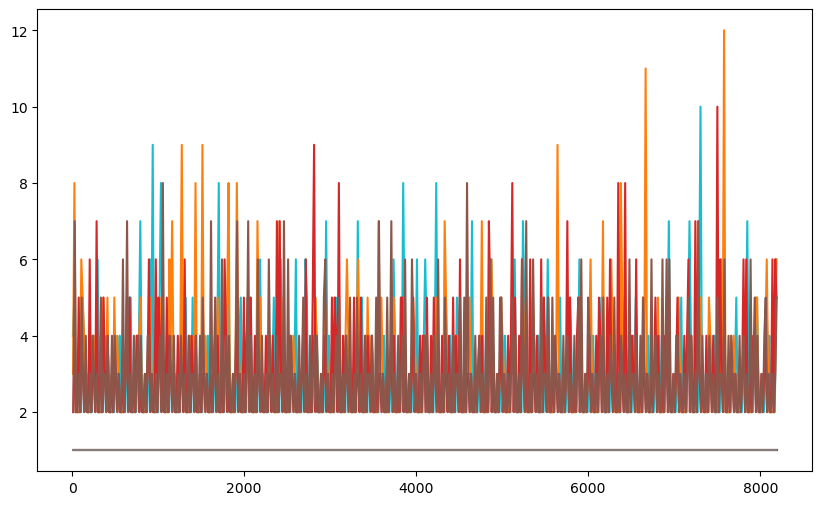

In [385]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
for i in range(16):
    plt.plot(X[i], Y[i])
plt.show()

In [386]:
mrTupValue(mrTupFromPath('0111'))

(5, 1)

In [387]:
mrTupValue(mrTupFromPath('0' + '11' + '111'))

(21, 1)

In [388]:
mrTupValue(mrTupFromPath('0' + '1111' + '111'))

(85, 1)

In [389]:
mrTupValue(mrTupFromPath('011' + '110' + '111'))

(53, 1)

In [390]:
mrTupValue(mrTupFromPath('011' + '110' + '011110' + '111'))

(373, 1)

In [391]:
mrTupValue(mrTupFromPath('011' + '110' + '011110' + '011110011110' + '111'))

(1525253, 81)

In [392]:
affineFunctionParamsFromPrefix("00")

(9, -5)

In [393]:
affineFunctionParamsFromPrefix("01")

(3, -1)